# Projet 4 : modèles prédictifs

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from P4_functions import *
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet, lasso_path
from sklearn.model_selection import learning_curve, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, validation_curve, learning_curve, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn import set_config
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Ce projet a été réalisé avec Python 3.8.8, **Matplotlib 3.4.2**, Pandas 1.2.4, Numpy 1.20.1, Seaborn 0.11.1. Vérifiez votre numéro de version :

In [4]:
print("Python", sys.version_info.major, ".", sys.version_info.minor)
print("Matplotlib", mpl.__version__)
print("Pandas", pd.__version__)
print("Nympy", np.__version__)
print("Seaborn", sns.__version__)
print("Scikit-learn", sklearn.__version__)

Python 3 . 8
Matplotlib 3.4.2
Pandas 1.2.4
Nympy 1.20.1
Seaborn 0.11.1
Scikit-learn 1.0.2


Le projet nécessite également l'installation de la librairie **XGBoost**. Merci de vérifier que vous la possédez bien ou de l'installer (https://xgboost.readthedocs.io/en/latest/install.html).

In [5]:
from xgboost import XGBRegressor

In [6]:
# Pour une meilleure visualisation :
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', '{:.3f}'.format)
set_config(display='diagram')
plt.rcParams.update({"figure.titlesize":16, "axes.titlesize":14, "axes.labelsize":13, "xtick.labelsize":13, "ytick.labelsize":13})

## Chargement des données

Ajoutez le chemin vers le dossier contenant les fichiers .csv ci-dessous :

In [7]:
path = "E:\Mes Docs\Sciences\Cours\OpenclassroomsDS-ML\Projet4"

In [8]:
path_data_models = os.path.join(path, "data_models.csv")

In [9]:
data_models = pd.read_csv(path_data_models,  encoding="utf-8", parse_dates=[1])

In [10]:
data_models.drop("Unnamed: 0", axis=1, inplace=True)

## Sélection des données

Le but est de pouvoir prédire la consommation d'énergie totale et les émissions du gaz à effet de serre à partir des seules informations disponibles lors de la construction du bâtiment. On ne garde donc que les informations commme le type de bâtiment, la surface, le nombre de bâtiments et d'étages, l'année de construction, le quartier, et le principal type d'usage du bâtiment.

Certaines variables de surface sont corrélées et risquent de poser problème, en particulier pour les modèles de régression linéaire. On ne garde ici que la surface dédiée à l'usage principal (`LargestPropertyUseTypeGFA`). On transforme également la variable `PropertyGFAParking` en variable binaire `True` / `False`selon si le bâtiment comporte un parking ou non.

Enfin, on crée une variable `MainEnergyUse` correspondant à la source d'énergie la plus utilisée. C'est une information qui ne nécessite pas de relevés de consommation et que l'on connait au moment de la construction du bâtiment.

In [11]:
data_models["MainEnergyUse"] = data_models[["SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]].idxmax(axis=1)
data_models["MainEnergyUse"].replace({"SteamUse(kBtu)":"SteamUse", "Electricity(kBtu)":"Electricity", 
                                      "NaturalGas(kBtu)":"NaturalGas"}, inplace=True)

data_models["Parking"] = np.where(data_models["PropertyGFAParking"]>0, True, False)

In [12]:
data_models.drop(["OSEBuildingID", "PropertyName", "Address", "City", "State", "ZipCode", "Latitude", "Longitude", 
                  "DataYear", "SourceEUI(kBtu/sf)", "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)",
                  "DefaultData", "ComplianceStatus","ListOfAllPropertyUseTypes", "PropertyGFATotal",
                  "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", "SiteEUI(kBtu/sf)", 
                  "ThirdLargestPropertyUseTypeGFA", "Outlier", "GHGEmissionsIntensity", "PropertyGFABuilding(s)", 
                  "PropertyGFAParking"], 
                 axis=1, inplace=True)

In [13]:
data_models.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,MainEnergyUse,Parking
0,NonResidential,Hotel,DOWNTOWN,1927,1.000,12.000,Hotel,88434.000,60.000,7226362.500,249.980,Electricity,False
1,NonResidential,Hotel,DOWNTOWN,1996,1.000,11.000,Hotel,83880.000,61.000,8387933.000,295.860,NaturalGas,True
2,NonResidential,Hotel,DOWNTOWN,1969,1.000,41.000,Hotel,756493.000,43.000,72587024.000,2089.280,Electricity,True
3,NonResidential,Hotel,DOWNTOWN,1926,1.000,10.000,Hotel,61320.000,56.000,6794584.000,286.430,Electricity,False
4,NonResidential,Hotel,DOWNTOWN,1980,1.000,18.000,Hotel,123445.000,75.000,14172606.000,505.010,NaturalGas,True


On définit les données (data) et les variables à prédire (targets). Dans notre cas, on cherche à prédire la consommation électrique totale du/des bâtiment(s) (`SiteEnergyUse(kBtu)`) et les émissions de gaz à effet de serre (`TotalGHGEmissions`). De plus, on va privilégier une prédiction sur le log des valeurs étant donné la distribution très étendue constatée dans l'analyse préparatoire. 

On va aussi créer un couple de datasets avec et sans l'"energy star score" pour tester son utilité. On supprimera les lignes n'ayant pas cette information pour ce dataset.

Enfin, on va dès à présent effectuer une partition données d'entraînement/données de test. Cela est nécessaire, en particulier lors de la recherche d'hyperparamètres optimaux, pour s'assurer que l'évaluation du modèle se fait sur des données totalement différentes du paramétrage.

Au total, on aura 3 jeux de données (data) - variables à prédire (targets) :
* data avec "energy star score" et targets log(site energy use) et log(total GHG emissions)
* data sans "energy star score" (même bâtiments que le dataset avec cette variable pour comparer les résultats) et targets log(site energy use) et log(total GHG emissions)
* data sans "energy star score" (dataset plus complet comprenant aussi les bâtiments n'ayant pas cette données) et targets log(site energy use) et log(total GHG emissions)

In [14]:
# Pour comparaison avec/sans energy star score :
data_ess = data_models[~data_models["ENERGYSTARScore"].isna()].drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], axis=1)
data_no_ess = data_models[~data_models["ENERGYSTARScore"].isna()].drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore"], axis=1)

targetSEUlog_ess = np.log(data_models[~data_models["ENERGYSTARScore"].isna()]["SiteEnergyUse(kBtu)"])
targetGHGElog_ess = np.log(data_models[~data_models["ENERGYSTARScore"].isna()]["TotalGHGEmissions"])

# Dataset plus complet :
data = data_models.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore"], axis=1)

targetSEUlog = np.log(data_models["SiteEnergyUse(kBtu)"])
targetGHGElog = np.log(data_models["TotalGHGEmissions"])

In [15]:
print(f"data {data.shape}")
print(f"data_ess {data_ess.shape}")
print(f"data_no_ess {data_ess.shape}")
print(f"targetSEUlog {targetSEUlog.shape}")
print(f"targetGHGElog {targetGHGElog.shape}")
print(f"targetSEUlog_ess {targetSEUlog_ess.shape}")
print(f"targetGHGElog_ess {targetGHGElog_ess.shape}")

data (1600, 10)
data_ess (1071, 11)
data_no_ess (1071, 11)
targetSEUlog (1600,)
targetGHGElog (1600,)
targetSEUlog_ess (1071,)
targetGHGElog_ess (1071,)


In [16]:
# Séparation train/test sets pour recherche hyperparamètres :

## Avec energy star score :
data_ess_train, data_ess_test, targetSEUlog_ess_train, targetSEUlog_ess_test = train_test_split(data_ess, targetSEUlog_ess, random_state=0, test_size=0.2)
data_ess_train, data_ess_test, targetGHGElog_ess_train, targetGHGElog_ess_test = train_test_split(data_ess, targetGHGElog_ess, random_state=0, test_size=0.2)

## Sans energy star score :
data_no_ess_train, data_no_ess_test, targetSEUlog_ess_train, targetSEUlog_ess_test = train_test_split(data_no_ess, targetSEUlog_ess, random_state=0, test_size=0.2)
data_no_ess_train, data_no_ess_test, targetGHGElog_ess_train, targetGHGElog_ess_test = train_test_split(data_no_ess, targetGHGElog_ess, random_state=0, test_size=0.2)

## Dataset plus complet :
data_train, data_test, targetSEUlog_train, targetSEUlog_test = train_test_split(data, targetSEUlog, random_state=0, test_size=0.2)
data_train, data_test, targetGHGElog_train, targetGHGElog_test = train_test_split(data, targetGHGElog, random_state=0, test_size=0.2)


In [17]:
print(f"data_train {data_train.shape}")
print(f"data_test {data_test.shape}")
print(f"data_ess_train {data_ess_train.shape}")
print(f"data_ess_test {data_ess_test.shape}")
print(f"targetSEUlog_train {targetSEUlog_train.shape}")
print(f"targetSEUlog_test {targetSEUlog_test.shape}")
print(f"targetGHGElog_ess_train {targetGHGElog_ess_train.shape}")
print(f"targetSEUlog_ess_test {targetSEUlog_ess_test.shape}")

data_train (1280, 10)
data_test (320, 10)
data_ess_train (856, 11)
data_ess_test (215, 11)
targetSEUlog_train (1280,)
targetSEUlog_test (320,)
targetGHGElog_ess_train (856,)
targetSEUlog_ess_test (215,)


Petit résumé des fichiers data et targets utilisés par la suite et de leur caractéristiques :

Data | Nb lignes dataset total | Nb lignes train | Nb lignes test | Nb colonnes | Targets | Description
-----|-------------------------|-----------------|----------------|-------------|---------|------------
data_ess | 1071 | 856 | 215| 11 | targetSEUlog_ess et targetGHGElog_ess (train et test) | Fichier des données nettoyées ( notamment, suppression des lignes avec valeurs manquantes pour l'energy star score) avec colonne energy star score
data_no_ess | 1071 | 856 | 215 | 10 | targetSEUlog_ess et targetGHGElog_ess (train et test) | Fichier des données nettoyées ( notamment, suppression des lignes avec valeurs manquantes pour l'energy star score) sans colonne energy star score
data | 1600| 1280 | 320 | 10 | targetSEUlog et targetGHGElog (train et test) |  Fichier des données nettoyées (y compris bâtiments sans données energy star score) sans colonne energy star score

A noter, les variables catégorielles que l'on a gardées sont déséquilibrées (effectifs très différents selon les classes).

In [18]:
data.LargestPropertyUseType.value_counts()

Office                                                  490
Non-Refrigerated Warehouse                              196
K-12 School                                             126
Retail Store                                             97
Other                                                    95
Hotel                                                    74
Worship Facility                                         70
Distribution Center                                      54
Medical Office                                           41
Supermarket/Grocery Store                                39
Parking                                                  27
Self-Storage Facility                                    27
Other - Recreation                                       26
College/University                                       22
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
Residence Hall/Dormitory                

In [19]:
data.BuildingType.value_counts()

NonResidential        1418
SPS-District K-12       84
Nonresidential COS      78
Campus                  19
Nonresidential WA        1
Name: BuildingType, dtype: int64

## Modèles et prédictions

On définit une fonction pour automatiser le fit et predict sur un train/test set et nous donner quelques metrics d'évaluations et graphs.

In [20]:
def multi_target_train_test(preprocessor, list_estimators, estimators_names, data, list_targets, list_targets_names, 
                            test_size=0.2,):
    
    """
    Perform a split into train and test set, fit and predict a model, as well as display a few metrics (score, MAE, MSE) 
    and plot predicted vs. real values of the target. Up to 9 different targets and corresponding estimators
    can be used (on the same data).
    
    preprocessor:
        Preprocessor used in the modeling (must be the same for all targets).
    
    list_estimators: list of str
        List of estimators, one for each target.
    
    estimators_names: str
        List of estimators names using string format (order corresponding to the list_estimators input).
    
    data:
        Data to split and on which fit and predict will be used (must be the same for all targets).
    
    list_targets: list
        List containing the targets to predict (order corresponding to the list_estimators input).
    
    list_targets_names: list of str
        List containing the targets names using string format (order corresponding to the list_targets input).
    
    test_size: int or float
        Size of test set, default is 0.2 meaning 20% of the total dataset.
    
    """
    
    # Check:
    if len(list_estimators)!=len(list_targets):
        print("Need one estimator per target.")
    if len(list_targets)!=len(list_targets_names):
        print("Need as many target names as targets.")
    if len(list_estimators)!=len(estimators_names):
        print("Need as many estimators names as estimators.")
    
    # Set-up figures:
    n = len(list_targets)
    if n == 1 :
        figsize = (6,6)
    elif n == 2:
        figsize =(16, 16)
    elif n == 3:
        figsize = (18, 16)
    elif n >= 4 and n <= 7:
        figsize = (18, 22)
    elif n >=8 and n<=9:
        figsize = (18, 30)
    else:
        print("Too many targets! maximum is 9.")

    subplot = range(331, 331+n)
    
    possible_colors = ["steelblue", "coral", "olivedrab", "teal", "peru", 
                       "mediumorchid", "seagreen", "crimson", "orange"]
    colors = possible_colors[:n]
    
    fig = plt.figure(figsize=figsize, tight_layout=True)
    
    fig.suptitle(f"Valeurs réelles vs. prédites sur le test set")
    
    for estimator, estimator_name, target, target_name, subplot, color in zip(list_estimators, estimators_names, 
                                                                                list_targets, list_targets_names, 
                                                                                subplot, colors):
        # Set-up pipeline:
        model = make_pipeline(preprocessor, estimator)
        est = str(estimator)
        
        # Make train-test and display metrics:
        data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42, 
                                                                            test_size=test_size)
        model.fit(data_train, target_train)
        target_predicted = model.predict(data_test)

        score = model.score(data_test, target_test)
        mae = mean_absolute_error(target_test, target_predicted)
        mse = mean_squared_error(target_test, target_predicted)
        print(f"{target_name}")
        print(f"Score {estimator_name} : {score:.2f}")
        print(f"MAE {estimator_name} : {mae:.2e}")
        print(f"MSE {estimator_name} : {mse:.2e}")
        
        # Get best parameters in case of cross-validation included:
        if "LinearRegression" in est:
            print(f"Regression coefficients: {[round(x,3) for x in model.named_steps['linearregression'].coef_]}")
            print(f"Regression intercept: {model.named_steps['linearregression'].intercept_:.3f}")
        elif "RidgeCV" in est:
            try:
                print(f"Ridge best alpha: {model.named_steps['ridgecv'].alpha_:.3f}")
            except KeyError:
                print(f"Ridge best alpha: {model.named_steps['pipeline']['ridgecv'].alpha_:.3f}")
            else:
                print(f"Ridge best alpha: {model.named_steps['ridgecv'].alpha_:.3f}")
        elif "LassoCV" in est:
            print(f"Lasso best alpha: {model.named_steps['lassocv'].alpha_:.3f}")
        elif "ElasticNetCV" in est:
            print(f"ElasticNet best alpha: {model.named_steps['elasticnetcv'].alpha_:.3f}")
        print(f"----------------------------------------")
        
        # Make plots
        ax = fig.add_subplot(subplot)
        ax.scatter(target_test, target_predicted, alpha=0.5, color=color)
        ax.plot(target_test, target_test, color="seagreen")
        ax.set_title(estimator_name)
        ax.set_xlabel(target_name)
        ax.set_ylabel("Prediction")
        ax.grid(True, linewidth=1);


On crée une fonction généraliste pour mettre en forme les résultats d'une cross-validation avec plusieurs metrics.

In [21]:
def get_all_scores(model_name, cv_results, list_scores, train_score=False):
    
    """
    Create a Series containing metrics values from cross-validation output.
    Take in input the model name, the object containing the cross-validation results, 
    the list of metrics used in the CV and a boolean indicating if train scores were returned or not.
    Return a Series with fit time, score time and the mean of each metric defined in list_scores.
    
    model_name: str
        Model name that will be used to fill the first column of the final dataframe.
        
    cv_results:
        Output of a cross-validation.
    
    list_scores: list of str
        List of metrics used in the cross-valisation.
    
    train_score: boolean
        Whether the cross-validation contains train scores or not. Default is False.
    
    """
    
    # Make a dataframe of the cross_validation results and set some variables
    cv_results = pd.DataFrame(cv_results)
    test_scores = []
    train_scores = []
    n = len(list_scores)
    
    # Add "test_" to the name of list of metrics
    for i in list_scores:
        i = "test_" + i
        test_scores.append(i)
    
    # Create a Series with basic info
    mean_results = pd.DataFrame([[model_name, cv_results["fit_time"].mean(), cv_results["score_time"].mean()]],
                             columns=["model_name", "fit_time", "score_time"])
    
    # If train score was return by cross_validation, create a list with appropriate names
    if train_score==True:
        for i in list_scores:
            i = "train_" + i
            train_scores.append(i)
            
        # Add means for train metrics
        for i in range (0, n):
            mean_results[train_scores[i]] = cv_results[train_scores[i]].mean()
    
    # Add means for test metrics
    for i in range (0, n):
            mean_results[test_scores[i]] = cv_results[test_scores[i]].mean()
    
    return mean_results

On définit les metrics que l'on va utiliser :

In [22]:
scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "neg_mean_squared_error", "neg_root_mean_squared_error", "r2"]

Et on crée une fonction plus spécifique pour ce projet qui permettra de :
* Faire un shuffle split
* Réaliser une cross-validation
* Mettre en forme les résultats de la cross-validation avec la fonction précédente (get_all_scores)
* Comparer les distributions des moyennes de la RMSE pour les train et validation sets

Tout cela pour nos 2 variable à prédire : la consommation d'énergie totale et les émissions de gaz à effet de serre totales.

In [23]:
def custom_cv(preprocessor, estimator_SEU, estimator_GHGE, name_model, data, target_SEU, target_GHGE, scoring, n_splits=30):
    
    """
    Make a cross-validation on the two targets to predict (site energy use and GHG emissions) using a shuffle split.
    Use the get_all_scores function to format the resulting metrics.
    Plot histograms of the mean absolute percentage error for train and test sets.
    Return the cross-validation results and Series with metrics for the two targets.
    
    preprocessor:
        Preprocessor to use in the modeling.
    
    estimator_SEU:
        Estimator to use to fit and predict Site Energy Use.
    
    estimator_GHGE:
        Estimator to use to fit and predict GHG emissions.
    
    name_model: str
        Name of the model that will be used in the Series returning the metrics of the cross-validation.
    
    data:
        Data that will be used in the cross-validation
    
    target_SEU:
        Site Energy Use target.
    
    target_GHGE:
        GHG Emissions target.
    
    scoring: list of str
        List of the metrics to use in the cross-validation.
    
    n_splits:
        Number of splits for the cross-validation (default is 30).
    
    """
    
    # Set-up models
    model_SEU = make_pipeline(preprocessor, estimator_SEU)
    model_GHGE = make_pipeline(preprocessor, estimator_GHGE)
    
    # Make suffle split and cross-validate
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)

    cv_results_SEU = cross_validate(model_SEU, data, target_SEU, cv=cv, n_jobs=-2, return_estimator=True, 
                                    return_train_score=True, scoring=scoring)
    cv_results_GHGE = cross_validate(model_GHGE, data, target_GHGE, cv=cv, n_jobs=-2, return_estimator=True, 
                                     return_train_score=True, scoring=scoring)
    
    # Format metrics output
    models_summary_SEU = get_all_scores(name_model, cv_results_SEU, scoring, train_score=True)
    models_summary_GHGE = get_all_scores(name_model, cv_results_GHGE, scoring, train_score=True)
    
    cv_results_SEU_df = pd.DataFrame(cv_results_SEU)
    cv_results_GHGE_df = pd.DataFrame(cv_results_GHGE)
    
    RMSE_SEU = -cv_results_SEU_df[["train_neg_root_mean_squared_error", "test_neg_root_mean_squared_error"]]
    
    RMSE_GHGE = -cv_results_GHGE_df[["train_neg_root_mean_squared_error","test_neg_root_mean_squared_error"]]
    
    # Plot histograms of train vs. test error
    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    sns.histplot(ax=ax[0], data=RMSE_SEU, legend=False)
    ax[0].legend(labels=["Validation", "Train"])
    ax[0].set_xlabel("Root mean squared error")
    ax[0].set_title("Train vs. Validation set\nSite Energy Use (kBtu)")

    sns.histplot(ax=ax[1], data=RMSE_GHGE, legend=False)
    ax[1].legend(labels=["Validation", "Train"])
    ax[1].set_xlabel("Root mean squared error")
    ax[1].set_title("Train vs. Validation set\nGHGE");
    
    return cv_results_SEU, cv_results_GHGE, models_summary_SEU, models_summary_GHGE

Voici une autre fonction permettant de faire :
* Un `ShuffleSplit`
* Une grid search avec cross-validation (`GridSearchCV`) pour trouver les meilleurs hyperparamètres
* Utiliser et évaluer le meilleur modèle sur des données **différentes** de celles de la grid search (test set)
* Afficher les valeurs prédites vs. valeurs réelles pour ce modèle

In [24]:
def GS_eval(preprocessor, estimator, model_name, data_train, list_target_train, params_GS, scoring, refit,
            data_test, list_target_test, list_targets_names, n_splits=10, test_size=0.2):
    
    """
    Make a shuffle split, then a grid search including cross-validation (GridSearchCV), keep the best 
    hyperparameters and use them to predict the targets on a separate dataset. Then, display predicted vs. 
    real values of the targets.
    Up to 9 targets can be used (prediction from the same data).
    
    preprocessor:
        Preprocessor to be used in the modeling (same for all targets).
    
    estimator:
        Estimator to be used in the modeling (same for all targets).
        
    model_name: str
        Model name used in return scoring results.
    
    data_train:
        Data used to make the GridSearchCV (will be split into train and test sets for cross-validation incuded 
        into the grid search).
    
    list_target_train: list
        List of targets (maximum is 9).
    
    params_GS: dict
        Dictionnary containing the hyperparameters to test.
    
    scoring: str or list of str
        Metrics that will be stored in the dataframe output summarizing results (string format as used in 
        grid search and cross-validate functions of sklearn).
    
    refit: str
        Metric used to select the best model.
    
    data_test:
        Data used to predict the targets with the best hyperparameters.
    
    list_target_test: list
        List of targets to predict with the best hyperparameters.
    
    list_targets_names: list of str
        List of targets names for display.
    
    n_splits: int
        Number of splits for the shuffle split procedure. Default is 10.
    
    test_size: int of float
        Test size of the shuffle split. Default is 0.2, meaning 20% of the data kept for grid search testing.
    
    """
    
    # Check:
    if len(list_target_train)!=len(list_target_test):
        print("Need as many targets for train and test.")
    if len(list_target_train)!=len(list_targets_names):
        print("Need as many target names as targets.")
    
    # Set-up figures:
    n = len(list_targets_names)
    if n == 1 :
        figsize = (6,6)
    elif n == 2:
        figsize =(16, 16)
    elif n == 3:
        figsize = (18, 16)
    elif n >= 4 and n <= 7:
        figsize = (18, 22)
    elif n >=8 and n<=9:
        figsize = (18, 30)
    else:
        print("Too many targets! maximum is 9.")

    subplot = range(331, 331+n)
    possible_colors = ["steelblue", "coral", "olivedrab", "teal", "peru", 
                       "mediumorchid", "seagreen", "crimson", "orange"]
    colors = possible_colors[:n]
    fig = plt.figure(figsize=figsize, tight_layout=True)
    fig.suptitle(f"Valeurs réelles vs. prédites sur le test set avec les meilleurs paramètres")
    
    # Set-up pipeline
    model=make_pipeline(preprocessor, estimator)
    
    # Make a grid search from a shuffle split:
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    
    model_grid_search = GridSearchCV(model, param_grid=params_GS, cv=cv, n_jobs=-2, scoring=scoring, refit=refit,
                                     return_train_score=True)
    
    # Modify metrics names to retrieve cross-validation results from output:
    train_scores = ["mean_fit_time", "mean_score_time"]
    for score in scoring:
        score = "mean_train_" + score
        train_scores.append(score)
    rank_refit = "rank_test_" + refit
    model_name_df = pd.DataFrame([model_name], columns=["model_name"])
    
    # Define dictionnary that will contain results for all targets:
    mean_results = {}
            
    for target_train, target_name, target_test, subplot, color in zip(list_target_train, list_targets_names, 
                                                                      list_target_test, subplot, colors):
        
        # Fit model and get best params:
        model_grid_search.fit(data_train, target_train)

        print(f"Best params {target_name}: {model_grid_search.best_params_}")
        
        # Get train scores for all metrics:
        cv_results = pd.DataFrame(model_grid_search.cv_results_)
        best_model_results = cv_results[rank_refit]==1
        train_results = cv_results[best_model_results][train_scores]
        train_results.reset_index(inplace=True)
        
        # Use model with best params to evaluate it on a separate test set:
        target_predicted = model_grid_search.predict(data_test)
        
        # Get a few metrics on the test set:
        score = model_grid_search.score(data_test, target_test)
        mae = mean_absolute_error(target_test, target_predicted)
        mape = mean_absolute_percentage_error(target_test, target_predicted)
        mse = mean_squared_error(target_test, target_predicted)
        rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
        r2 = r2_score(target_test, target_predicted)
        
        # Make a dataframe containing train and test scores and insert it in dictionnary:
        test_results = []
        test_results = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]],
                                  columns=["test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error",
                                          "test_neg_mean_squared_error", "test_neg_root_mean_squared_error", "test_r2"])
        results_target = pd.concat([model_name_df, train_results, test_results], axis=1)
        results_target.drop("index", axis=1, inplace=True)
        results_target.rename(columns={"mean_fit_time": "fit_time", "mean_score_time":"score_time", 
                               "mean_train_neg_mean_absolute_error":"train_neg_mean_absolute_error",
                              "mean_train_neg_mean_absolute_percentage_error":"train_neg_mean_absolute_percentage_error",
                              "mean_train_neg_mean_squared_error":"train_neg_mean_squared_error",
                              "mean_train_neg_root_mean_squared_error":"train_neg_root_mean_squared_error",
                              "mean_train_r2":"train_r2"}, inplace=True)
        mean_results[target_name] = results_target
        
        # Display a few test metrics: 
        print(f"Score : {score:.2f}")
        print(f"MAE : {mae:.2e}")
        print(f"RMSE : {rmse:.2e}")
        print("-----------------------------------------")
        
        # Plot predicted vs. real values:
        ax = fig.add_subplot(subplot)
        ax.scatter(target_test, target_predicted, alpha=0.5, color=color)
        ax.plot(target_test, target_test, color="seagreen")
        ax.set_xlabel(target_name)
        ax.set_ylabel("Prediction")
        ax.grid(True, linewidth=1);
    
    return mean_results

Enfin, on veut pouvoir effectuer le même type de procédure mais pour les fonctions `RidgeCV`, `LassoCV`et `ElasticNetCV` qui incluent la cross-validation avec la recherche du meilleur hyperparamètre alpha.

In [25]:
def linearregression_cv(preprocessor, estimator, alphas, model_name, data_train, list_target_train,
            data_test, list_target_test, list_targets_names):
    
    """
    To use when doing a linear regression including a cross-validation (RidgeCV, LassoCV, ElasticNetCV).
    Take in argument preprocessor, estimator, target(s), data and target train and test sets, and tested alphas.
    Display best alpha found and main metrics. Plot predicted vs. true values for each target as well
    as MSE vs. alphas curve.
    Return a dictionnary containing a dataframe with cross-validation results for each target 
    (key = target name as in the input list_targets_names, value = dataframe with cv results).
    Alphas must be given both in the estimator arguments and as a function argument.
    store_cv_values must be set to True if using RidgeCV.
    When evaluating the model on the test set, will use the best alpha found with default settings of Ridge, 
    Lasso or ElasticNet functions.
    
    preprocessor:
        Preprocessor to be used in the modeling (same for all targets).
    
    estimator:
        Estimator to be used in the modeling (same for all targets). Must specify alphas to test in the 
        estimator's arguments. store_cv_values must be set to True if using RidgeCV.
        
    alphas: list of int or float, np.array
        Alphas to be tested in the cross-validation (must be the same as in estimator's argument).
        
    model_name: str
        Model name used in return scoring results.
    
    data_train:
        Data used to make the GridSearchCV (will be split into train and test sets for cross-validation incuded 
        into the grid search).
    
    list_target_train: list
        List of targets.
    
    data_test:
        Data used to predict the targets with the best hyperparameters.
    
    list_target_test: list
        List of targets to predict with the best hyperparameters.
    
    list_targets_names: list of str
        List of targets names for display.
    
    """
    
    # Check:
    if len(list_target_train)!=len(list_target_test):
        print("Need as many targets for train and test.")
    if len(list_target_train)!=len(list_targets_names):
        print("Need as many target names as targets.")
    
    # Set-up figures:
    n = len(list_target_train)
    axes = range(n)
    possible_colors = ["steelblue", "coral", "olivedrab", "teal", "peru", 
                       "mediumorchid", "seagreen", "crimson", "orange"]
    colors = possible_colors[:n]
    fig, ax = plt.subplots(n, 2, figsize=(10, n*5), tight_layout=True)
    fig.suptitle(f"{model_name}")
    
    # Set-up pipeline
    model = make_pipeline(preprocessor, estimator)
    est = str(estimator)
    
    # Define dictionnary that will contain cross-validation results for all targets:
    results_test = {}
    
    # For each taget:
    for axe, target_train, target_name, target_test, color in zip(axes, list_target_train, list_targets_names, 
                                                                      list_target_test, colors):
        
        # Fit model:
        model.fit(data_train, target_train)
        
        # Get best alpha and results of cross-validation:
        print(f"{target_name}")
        if "RidgeCV" in est:
            try:
                print(f"Ridge best alpha: {model.named_steps['ridgecv'].alpha_:.3f}")
            except KeyError:
                cv_results = model.named_steps['pipeline']['ridgecv'].cv_values_
                best_alpha = model.named_steps['pipeline']['ridgecv'].alpha_
                print(f"Ridge best alpha: {best_alpha:.3f}")
            else:
                cv_results = model.named_steps['ridgecv'].cv_values_
                best_alpha = model.named_steps['ridgecv'].alpha_
                print(f"Ridge best alpha: {best_alpha:.3f}")
            
            # Make model with best alpha:
            #best_model = make_pipeline(preprocessor, Ridge(alpha=best_alpha, random_state=0))
            # Make MSE vs. alpha Series:
            errors = pd.DataFrame(cv_results)
            errors.columns = list(alphas)
            errors_alphas = errors.mean()
            errors_alphas_std = errors.std()
            
        elif "LassoCV" in est:
            best_alpha = model.named_steps['lassocv'].alpha_
            print(f"Lasso best alpha: {best_alpha:.3f}")
            
            # Make model with best alpha:
            #best_model = make_pipeline(preprocessor, Lasso(alpha=best_alpha, random_state=0))
            
            # Get MSE paths and make MSE vs. alphas Series:
            mse = model.named_steps['lassocv'].mse_path_.mean(axis=1)
            errors_alphas = pd.Series(mse, index=alphas)
            
            #eps = alphas.min() / alphas.max()
            #alphas_lasso, coefs_lasso, _ = lasso_path(data_train, target_train, eps=eps, alphas=alphas)
            
        elif "ElasticNetCV" in est:
            best_alpha = model.named_steps['elasticnetcv'].alpha_
            print(f"ElasticNet best alpha: {best_alpha:.3f}")
            
            # Make model with best alpha:
            #best_model = make_pipeline(preprocessor, ElasticNet(alpha=best_alpha, random_state=0))
            
            # Get MSE paths and make MSE vs. alphas Series:
            mse = model.named_steps['elasticnetcv'].mse_path_.mean(axis=1)
            errors_alphas = pd.Series(mse, index=alphas)
            
        # Use model with best alpha to evaluate it on a separate test set:
        #best_model.fit(data_train, target_train)
        #target_predicted_train = best_model(data_train)
        target_predicted = model.predict(data_test)
        
        # Get metrics on the test set:
        score = model.score(data_test, target_test)
        mae = mean_absolute_error(target_test, target_predicted)
        mape = mean_absolute_percentage_error(target_test, target_predicted)
        mse = mean_squared_error(target_test, target_predicted)
        rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
        r2 = r2_score(target_test, target_predicted)
        results_test[target_name] = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]], 
                                    columns=["test_neg_mean_absolute_error", 
                                             "test_neg_mean_absolute_percentage_error", 
                                             "test_neg_mean_squared_error", 
                                             "test_neg_root_mean_squared_error", "test_r2"])
        # Display a few test metrics: 
        print(f"Score : {score:.2f}")
        print(f"MAE : {mae:.2e}")
        print(f"RMSE : {rmse:.2e}")
        print("-----------------------------------------")
        
        # Plot predicted vs. real values:
        ax[axe, 0].scatter(target_test, target_predicted, alpha=0.5, color=color)
        ax[axe, 0].plot(target_test, target_test, color="seagreen")
        ax[axe, 0].set_xlabel(target_name)
        ax[axe, 0].set_ylabel("Prediction")
        ax[axe, 0].set_title("Valeurs réelles vs. prédites sur le test set\navec le meilleur alpha")
        ax[axe, 0].grid(True, linewidth=1)
        
        # Plot errors vs. alphas:
        ax[axe, 1].plot(errors_alphas, marker="+", color=color)
        ax[axe, 1].semilogx()
        ax[axe, 1].set_ylabel(f"MSE pour {target_name}")
        ax[axe, 1].set_xlabel("Alpha")
        ax[axe, 1].set_title("Erreur quadratique moyenne pour les alphas testés", pad=20)
        
        #ax[axe, 2].plot(alphas_lasso, coefs_lasso, marker="+", color=color)
        #ax[axe, 2].semilogx()
        #ax[axe, 2].set_ylabel(f"Coef pour {target_name}")
        #ax[axe, 2].set_xlabel("Alpha")
        #ax[axe, 2].set_title("Coefficients en fonction de alpha", pad=20);
        
    return results_test

On sélectionne le preprocessing à effectuer en fonction du type de variables :
* OneHotEncoder pour les variables catégorielles
* StandardScaler pour les variables numériques

In [26]:
cat_col = data.select_dtypes(include=["object"]).columns
num_col = data.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'Parking']


In [27]:
cat_preprocessor = OneHotEncoder(handle_unknown="ignore")
num_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([("cat_preprocessor", cat_preprocessor, cat_col),
                                 ("num_preprocessor", num_preprocessor, num_col)])

### Modèle naïf : Dummy Regressor

Afin d'avoir une base de comparaison, on va utiliser un modèle naïf de régression : le dummy regressor. On garde la stratégie par défaut qui est de prédire systématiquement la moyenne du dataset.

log(Site Energy Use (kBtu))
Score Dummy Regressor : -0.01
MAE Dummy Regressor : 1.13e+00
MSE Dummy Regressor : 1.93e+00
----------------------------------------
log(Total GHG Emissions)
Score Dummy Regressor : -0.00
MAE Dummy Regressor : 1.26e+00
MSE Dummy Regressor : 2.63e+00
----------------------------------------


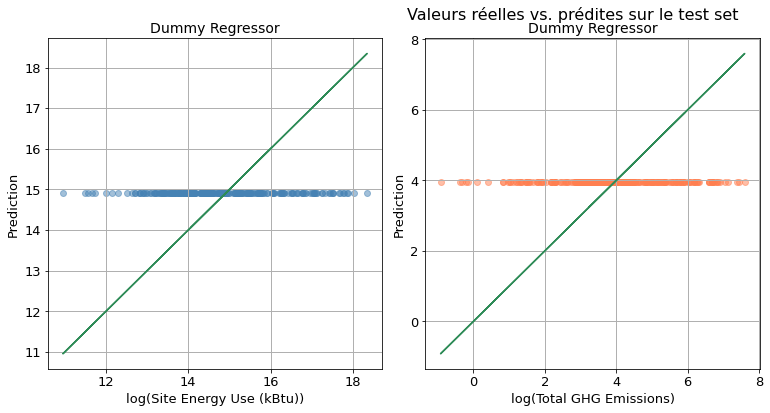

In [28]:
multi_target_train_test(preprocessor, [DummyRegressor(strategy="mean"), DummyRegressor(strategy="mean")],
                        ["Dummy Regressor", "Dummy Regressor"],
                        data_train, [targetSEUlog_train, targetGHGElog_train], ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

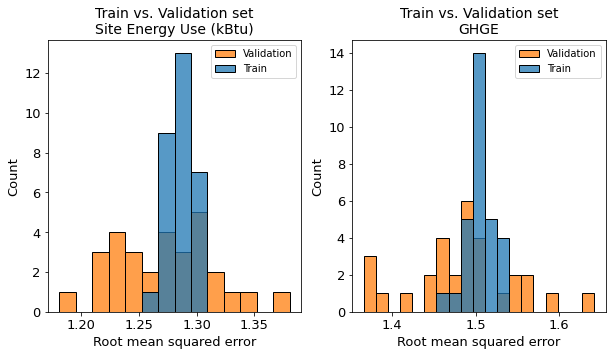

In [29]:
cv_results_SEU, cv_results_GHGE, models_summary_SEU, models_summary_GHGE = custom_cv(preprocessor, DummyRegressor(strategy="mean"), DummyRegressor(strategy="mean"), "Dummy Regressor", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [30]:
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005


In [31]:
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004


Sans surprise, les résultats du modèles sont très mauvais...

### Régression linéaire avec uniquement les variables numériques

On prend maintenant un modèle basique de régression linéaire utilisant uniquement les variables numériques.

In [32]:
preprocessor_numonly = ColumnTransformer([("num_preprocessor", num_preprocessor, num_col)])

log(Site Energy Use (kBtu))
Score Régression linéaire 
(variables numériques uniquement)) : 0.38
MAE Régression linéaire 
(variables numériques uniquement)) : 8.22e-01
MSE Régression linéaire 
(variables numériques uniquement)) : 1.19e+00
Regression coefficients: [0.134, 0.091, 0.006, 0.643, 0.213]
Regression intercept: 14.915
----------------------------------------
log(Total GHG Emissions)
Score Régression linéaire 
(variables numériques uniquement)) : 0.23
MAE Régression linéaire 
(variables numériques uniquement)) : 1.10e+00
MSE Régression linéaire 
(variables numériques uniquement)) : 2.03e+00
Regression coefficients: [0.07, 0.108, -0.075, 0.666, 0.126]
Regression intercept: 3.942
----------------------------------------


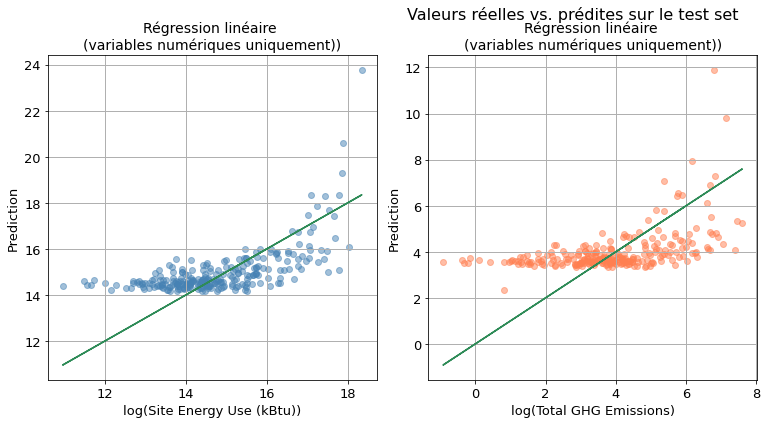

In [33]:
multi_target_train_test(preprocessor_numonly, [LinearRegression(), LinearRegression()],
                        ["Régression linéaire \n(variables numériques uniquement))", "Régression linéaire \n(variables numériques uniquement))"],
                        data_train, [targetSEUlog_train, targetGHGElog_train], ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

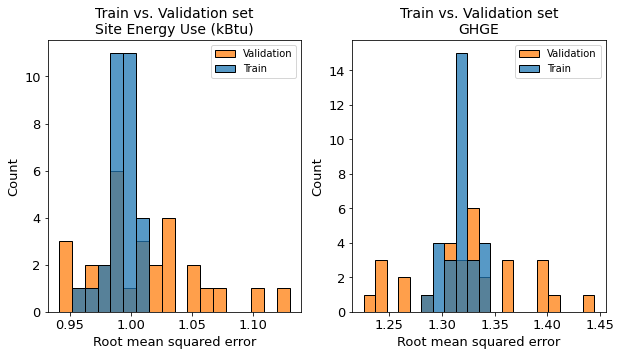

In [34]:
cv_results_SEU, cv_results_GHGE, model_SEU_01, model_GHGE_01 = custom_cv(preprocessor_numonly, LinearRegression(), LinearRegression(), "Linear regression num only", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

Les résultats des différentes metrics pour nos 2 variables à prédire :

In [35]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_01])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369


In [36]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_01])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202


Les résultats sont meilleurs que pour le dummy regressor, mais restent faibles.

Pour la variable "Site Energy Use" (consommation d'énergie), la RMSE est de 0.99 pour le train set et 1.01 pour le test set. Pour la variable "Total GHG Emissions" (émissions de gaz à effet de serre totales), laRMSE est encore plus forte, à 1.316 pour le train et 1.324 pour le test, aseez mauvais donc. Les autres valeurs permettant l'évaluation ci-dessus montrent que l'on est loin du compte.

Etant donné que l'on a utilisé uniquement des variables numériques, on peut récupérer les coefficients de la régression linéaire pour les différentes variables :

In [37]:
coefs_SEU = [est[-1].coef_ for est in cv_results_SEU["estimator"]]
weights_reg_SEU = pd.DataFrame(coefs_SEU, columns=num_col)
coefs_GHGE = [est[-1].coef_ for est in cv_results_GHGE["estimator"]]
weights_reg_GHGE = pd.DataFrame(coefs_GHGE, columns=num_col)

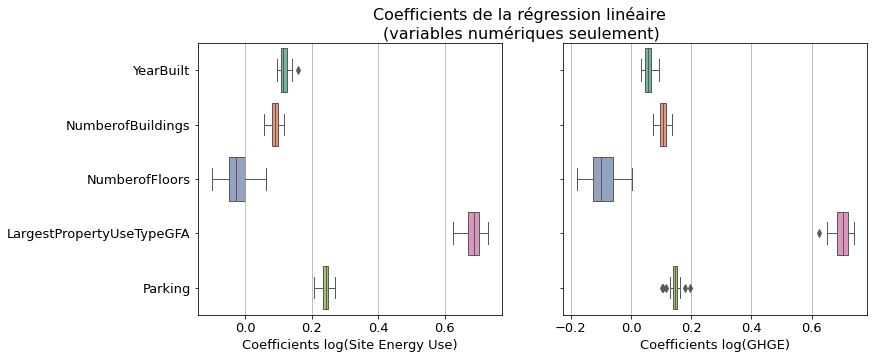

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

fig.suptitle(f'Coefficients de la régression linéaire \n(variables numériques seulement)')

sns.boxplot(ax=ax[0], data=weights_reg_SEU, orient="h", linewidth=1, palette="Set2")
ax[0].set_xlabel("Coefficients log(Site Energy Use)")
ax[0].grid(axis="x")

sns.boxplot(ax=ax[1], data=weights_reg_GHGE, orient="h", linewidth=1, palette="Set2")
ax[1].set_xlabel("Coefficients log(GHGE)")
ax[1].set_yticklabels("")
ax[1].grid(axis="x");

La surface dédiée à l'usage principal des bâtiments (`LargestPropertyUseType` ) et la présence/absence de parking sont les variables qui ont le plus de poids dans la régression linéaire.

### Regression linéaire avec variables numériques ET catégorielles

On utilise toujours un modèle de régression linéaire basique, mais cette fois avec les variables numériques et catégorielles.

In [39]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

log(Site Energy Use (kBtu))
Score Régression linéaire 
(variable numériques et catégorielles) : 0.54
MAE Régression linéaire 
(variable numériques et catégorielles) : 7.06e-01
MSE Régression linéaire 
(variable numériques et catégorielles) : 8.88e-01
Regression coefficients: [0.15, 0.021, -0.157, 0.633, 0.066, 0.37, -0.267, -0.2, 0.117, -0.02, -0.202, 0.763, 0.222, -0.232, -0.141, 0.357, -0.267, -0.008, -1.489, 0.183, 0.25, -0.105, -0.679, -0.164, -0.567, 0.361, -0.433, 3.29, -0.122, -0.499, -0.519, 0.091, -0.003, 0.199, -1.179, 0.328, 0.315, 0.014, 0.186, 0.058, -0.107, 0.138, 0.003, -0.093, 0.05, -1.031, -0.3, -0.584, -0.122, 2.384, -0.521, 0.09, 0.07, 0.763, 0.222, -0.232, 1.41, -0.687, 1.239, -0.572, 0.6, 0.032, 0.484, 0.409, -0.249, 0.209, -0.051, -0.352, -0.285, -0.57, 0.969, -0.836, 0.148, 1.956, -1.073, -0.802, 0.764, -1.684, 0.593, -0.283, 0.17, -0.592, -1.613, 0.25, -0.085, -0.105, 1.225, -0.038, -0.567, 0.361, -0.26, 0.097, -1.907, 1.474, -0.519, -0.366, 0.02, 0.346]
Regress

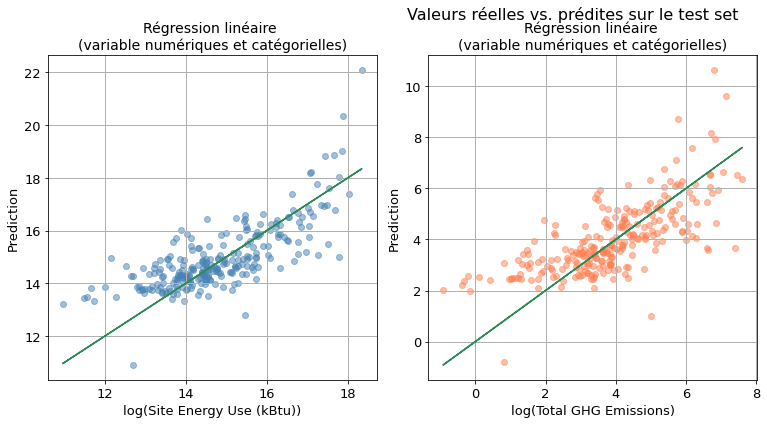

In [40]:
multi_target_train_test(preprocessor, [LinearRegression(), LinearRegression()], 
                        ["Régression linéaire \n(variable numériques et catégorielles)", "Régression linéaire \n(variable numériques et catégorielles)"],
                        data_train, [targetSEUlog_train, targetGHGElog_train], ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

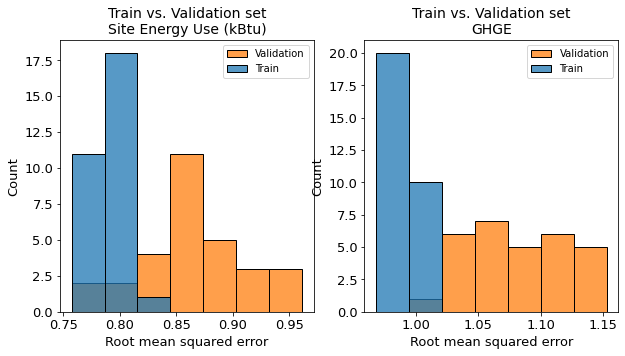

In [41]:
cv_results_SEU, cv_results_GHGE, model_SEU_02, model_GHGE_02 = custom_cv(preprocessor, LinearRegression(), LinearRegression(), "Linear regression num and cat", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [42]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_02])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532


In [43]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_02])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464


On a de l'amélioration pour les 2 variables à prédire : les erreurs diminuent.

### Régression Ridge

On va tester différentes valeurs de alpha (régularisation plus ou moins importante) :

In [44]:
alphas = np.logspace(-2, 1, num=25)

log(Site Energy Use (kBtu))
Ridge best alpha: 2.371
Ridge best alpha: 2.371
Score : 0.54
MAE : 6.53e-01
RMSE : 8.62e-01
-----------------------------------------
log(Total GHG Emissions)
Ridge best alpha: 4.217
Ridge best alpha: 4.217
Score : 0.46
MAE : 8.12e-01
RMSE : 1.05e+00
-----------------------------------------


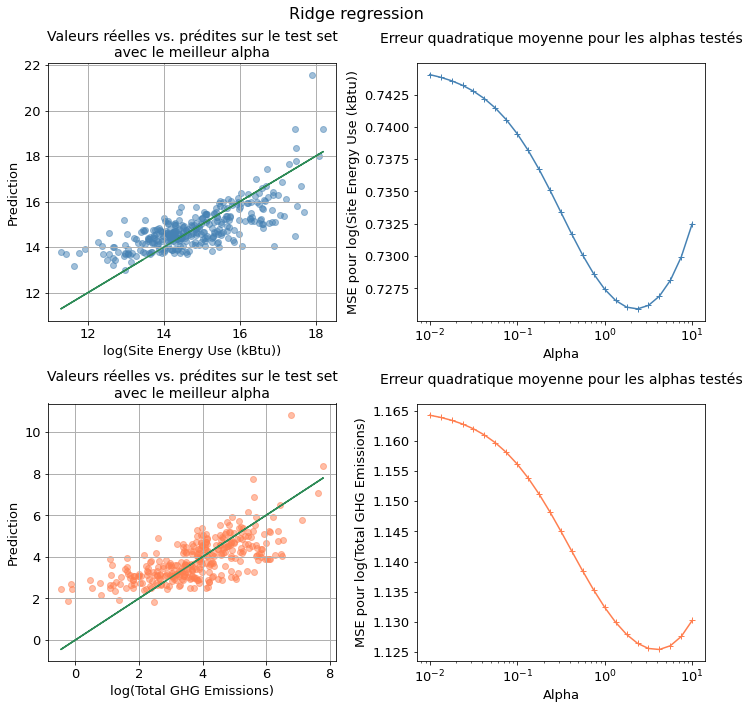

In [45]:
results_test = linearregression_cv(preprocessor, RidgeCV(alphas=alphas,  store_cv_values=True), alphas, "Ridge regression", 
                              data_train, [targetSEUlog_train, targetGHGElog_train], 
                              data_test, [targetSEUlog_test, targetGHGElog_test], 
                              ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

La meilleure valeur pour alpha se situe à environ 2,37  pour prédire le log de la consommation énergétique totale et 4,22 pour les émissions de gaz à effet de serre totales.

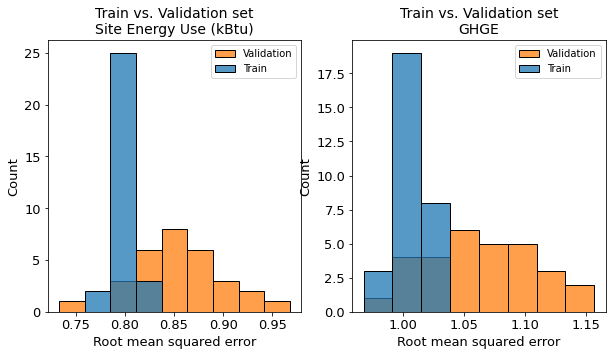

In [46]:
cv_results_SEU, cv_results_GHGE, model_SEU_03, model_GHGE_03 = custom_cv(preprocessor, RidgeCV(alphas=alphas, store_cv_values=True), RidgeCV(alphas=alphas, store_cv_values=True), "Ridge regression", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

On peut tester l'influence du nombre d'échantillons du training set sur la performance du modèle (*learning curve*) :

In [47]:
model = make_pipeline(preprocessor, Ridge(alpha=2.371))

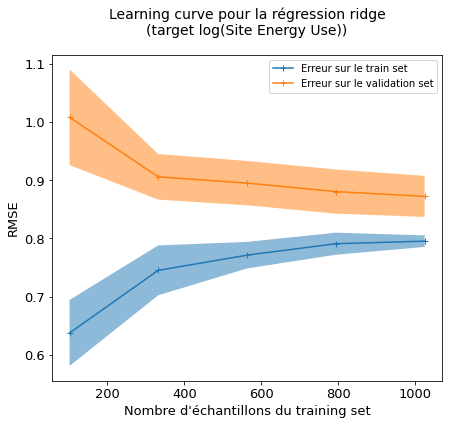

In [48]:
# On définit des tailles de train :
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

# Shuffle-split pour répartir les données en train/test :
cv = ShuffleSplit(n_splits=15, test_size=0.2, random_state=8)

# On utilise learning_curve :
results_lc = learning_curve(model, data_train, targetSEUlog_train, train_sizes=train_sizes, cv=cv,scoring="neg_root_mean_squared_error", 
                         n_jobs=-2)
train_size, train_scores, test_scores = results_lc[:3]

# Convertir les scores en erreurs :
train_errors, test_errors = -train_scores, -test_scores

# Plot de la courbe
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(train_size, train_errors.mean(axis=1), marker="+", label="Erreur sur le train set")
ax.plot(train_size, test_errors.mean(axis=1), marker="+", label="Erreur sur le validation set")

ax.fill_between(train_size, train_errors.mean(axis=1)+train_errors.std(axis=1), 
                train_errors.mean(axis=1)-train_errors.std(axis=1), alpha=0.5)
ax.fill_between(train_size, test_errors.mean(axis=1)+test_errors.std(axis=1), 
                test_errors.mean(axis=1)-test_errors.std(axis=1), alpha=0.5)

ax.legend()

ax.set_xlabel("Nombre d'échantillons du training set")
ax.set_ylabel("RMSE")
ax.set_title("Learning curve pour la régression ridge\n(target log(Site Energy Use))", pad=20);

On voit que l'on est dans une gamme de nombre de données correct pour l'apprentissage du modèle. Même si plus de données pourrait encore améliorer un peu les performances, les courbes des erreurs sur le train et test set arrivent à leur asymptote lorsqu'on utilise toutes les données disponibles pour le train.

In [49]:
model_SEU_03 = pd.concat([model_SEU_03[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_03 = pd.concat([model_GHGE_03[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [50]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_03])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536


In [51]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_03])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457


L'amélioration apportée par la régression ridge est très faible.

### Evaluation de l'utilité de l'energy star score (avec la régression ridge)

On va maintenant effectuer la régression ridge avec le double dataset avec/sans energy star score pour tester son utilité.

#### AVEC energy star score :

In [52]:
cat_col = data_ess.select_dtypes(include=["object"]).columns
num_col = data_ess.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Parking']


In [53]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

In [54]:
alphas = np.logspace(-2, 1, num=25)

log(Site Energy Use (kBtu))
Ridge best alpha: 0.562
Ridge best alpha: 0.562
Score : 0.70
MAE : 5.32e-01
RMSE : 6.92e-01
-----------------------------------------
log(Total GHG Emissions)
Ridge best alpha: 1.334
Ridge best alpha: 1.334
Score : 0.56
MAE : 7.57e-01
RMSE : 9.82e-01
-----------------------------------------


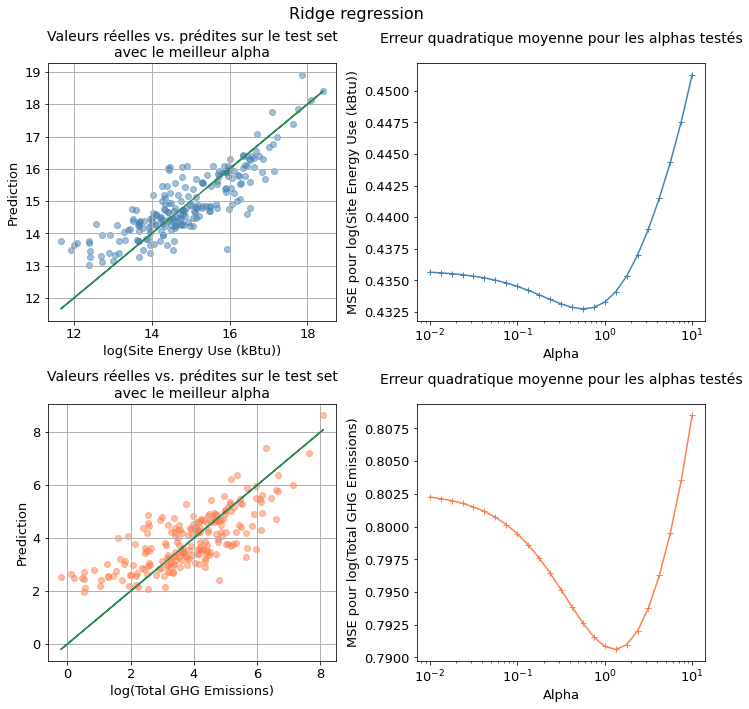

In [55]:
results_test = linearregression_cv(preprocessor, RidgeCV(alphas=alphas,  store_cv_values=True), alphas, "Ridge regression", 
                              data_ess_train, [targetSEUlog_ess_train, targetGHGElog_ess_train], 
                              data_ess_test, [targetSEUlog_ess_test, targetGHGElog_ess_test], 
                              ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

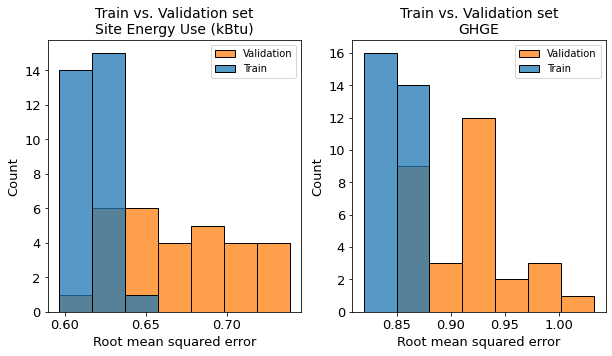

In [56]:
cv_results_SEU_ess, cv_results_GHGE_ess, model_SEU_ess, model_GHGE_ess = custom_cv(preprocessor, RidgeCV(alphas=alphas, store_cv_values=True), RidgeCV(alphas=alphas, store_cv_values=True), "Ridge regression with ESS", data_ess , targetSEUlog_ess, targetGHGElog_ess, scoring)

In [57]:
model_SEU_ess = pd.concat([model_SEU_ess[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_ess = pd.concat([model_GHGE_ess[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [58]:
model_SEU_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.104,0.010,-0.468,-0.032,-0.381,-0.617,0.748,-0.532,-0.037,-0.479,-0.692,0.702


In [59]:
model_GHGE_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.085,0.006,-0.662,-0.375,-0.726,-0.852,0.639,-0.757,-0.518,-0.964,-0.982,0.559


#### SANS energy star score :

In [60]:
cat_col = data_no_ess.select_dtypes(include=["object"]).columns
num_col = data_no_ess.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'Parking']


In [61]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

log(Site Energy Use (kBtu))
Ridge best alpha: 1.334
Ridge best alpha: 1.334
Score : 0.62
MAE : 5.84e-01
RMSE : 7.76e-01
-----------------------------------------
log(Total GHG Emissions)
Ridge best alpha: 1.778
Ridge best alpha: 1.778
Score : 0.47
MAE : 8.22e-01
RMSE : 1.07e+00
-----------------------------------------


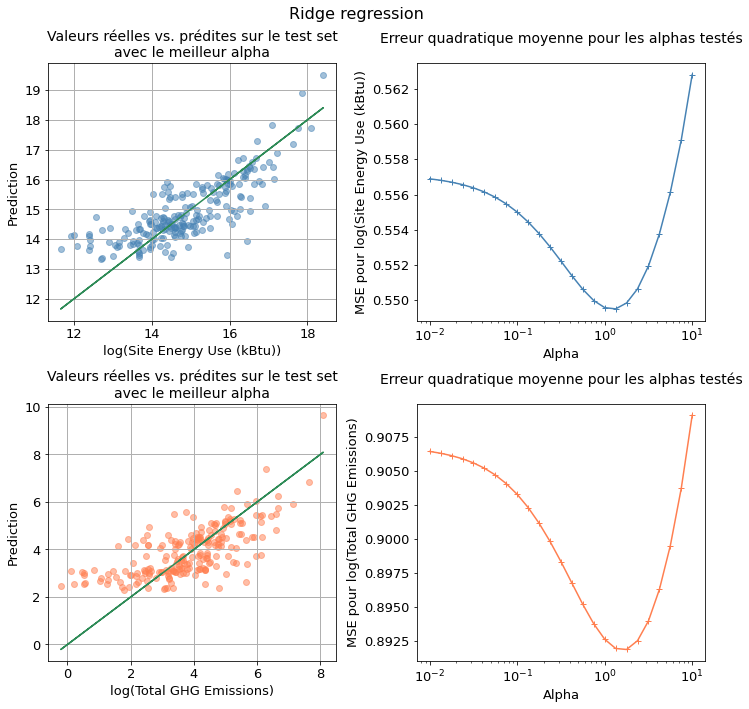

In [62]:
results_test = linearregression_cv(preprocessor, RidgeCV(alphas=alphas,  store_cv_values=True), alphas, "Ridge regression", 
                              data_no_ess_train, [targetSEUlog_ess_train, targetGHGElog_ess_train], 
                              data_no_ess_test, [targetSEUlog_ess_test, targetGHGElog_ess_test], 
                              ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

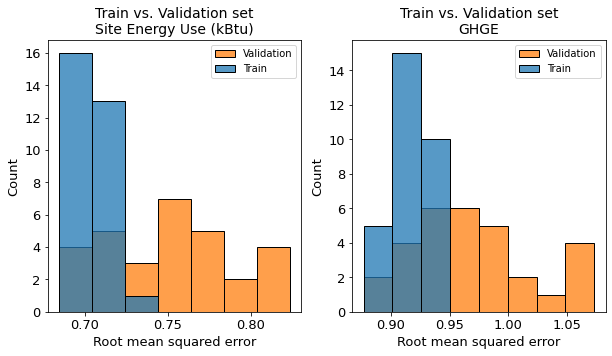

In [63]:
cv_results_SEU_ess, cv_results_GHGE_ess, model_SEU_ess_02, model_GHGE_ess_02 = custom_cv(preprocessor, RidgeCV(alphas=alphas, store_cv_values=True), RidgeCV(alphas=alphas, store_cv_values=True), "Ridge regression without ESS", data_no_ess , targetSEUlog_ess, targetGHGElog_ess, scoring)

In [64]:
model_SEU_ess_02 = pd.concat([model_SEU_ess_02[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_ess_02 = pd.concat([model_GHGE_ess_02[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [65]:
model_SEU_ess = pd.concat([model_SEU_ess, model_SEU_ess_02])
model_SEU_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.104,0.010,-0.468,-0.032,-0.381,-0.617,0.748,-0.532,-0.037,-0.479,-0.692,0.702
0,Ridge regression without ESS,0.075,0.006,-0.533,-0.036,-0.496,-0.704,0.672,-0.584,-0.040,-0.603,-0.776,0.625


In [66]:
model_GHGE_ess = pd.concat([model_GHGE_ess, model_GHGE_ess_02])
model_GHGE_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.085,0.006,-0.662,-0.375,-0.726,-0.852,0.639,-0.757,-0.518,-0.964,-0.982,0.559
0,Ridge regression without ESS,0.076,0.005,-0.707,-0.422,-0.842,-0.917,0.581,-0.822,-0.575,-1.150,-1.072,0.473


Les résultats sont très proches avec ou sans l'information apportée par l'energy star score : la RMSE passe de 0.776 à 0.692 pour la consommation d'énergie et de 1.072 à 0.982 pour les émissions. Le gain est très faible. A ce stade, et avec la régression ridge, cette variable ne semble pas importante pour la prédiction de la consommation ou des émissions.

### Régression LASSO

On refait le preprocessing pour tester la régression Lasso.

In [67]:
cat_col = data.select_dtypes(include=["object"]).columns
num_col = data.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'Parking']


In [68]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

In [69]:
alphas = np.logspace(-2, 2, num=25)

log(Site Energy Use (kBtu))
Lasso best alpha: 0.010
Score : 0.52
MAE : 6.63e-01
RMSE : 8.80e-01
-----------------------------------------
log(Total GHG Emissions)
Lasso best alpha: 0.010
Score : 0.44
MAE : 8.28e-01
RMSE : 1.07e+00
-----------------------------------------


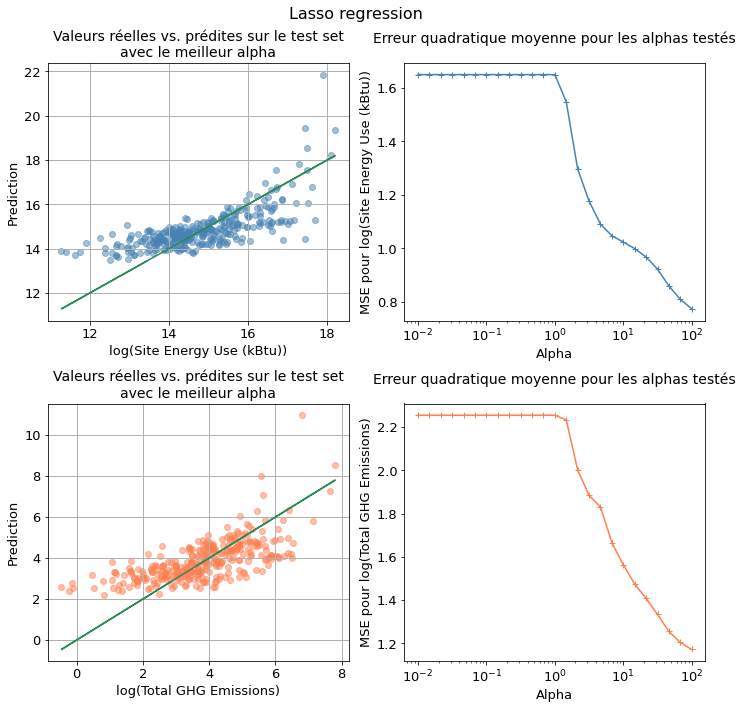

In [70]:
results_test = linearregression_cv(preprocessor, LassoCV(alphas=alphas), alphas, "Lasso regression", 
                              data_train, [targetSEUlog_train, targetGHGElog_train], 
                              data_test, [targetSEUlog_test, targetGHGElog_test], 
                              ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

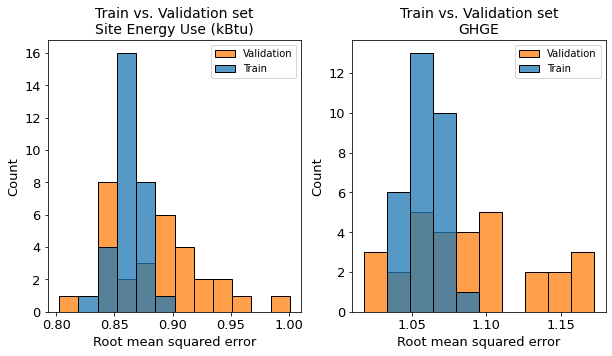

In [71]:
cv_results_SEU, cv_results_GHGE, model_SEU_04, model_GHGE_04 = custom_cv(preprocessor, LassoCV(alphas=alphas, n_jobs=-2, random_state=0), LassoCV(alphas=alphas, n_jobs=-2, random_state=0), "Lasso regression", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [72]:
model_SEU_04 = pd.concat([model_SEU_04[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_04 = pd.concat([model_GHGE_04[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [73]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_04])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516


In [74]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_04])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441


La régression Lasso fait un petit peu moins bien que la régression ridge.

On peut tenter la régression ElasticNet qui combine les régularisations lasso et ridge.

### Régression ElasticNet

In [75]:
alphas = np.logspace(-2, 2, num=25)

log(Site Energy Use (kBtu))
ElasticNet best alpha: 0.010
Score : 0.53
MAE : 6.55e-01
RMSE : 8.71e-01
-----------------------------------------
log(Total GHG Emissions)
ElasticNet best alpha: 0.010
Score : 0.45
MAE : 8.19e-01
RMSE : 1.06e+00
-----------------------------------------


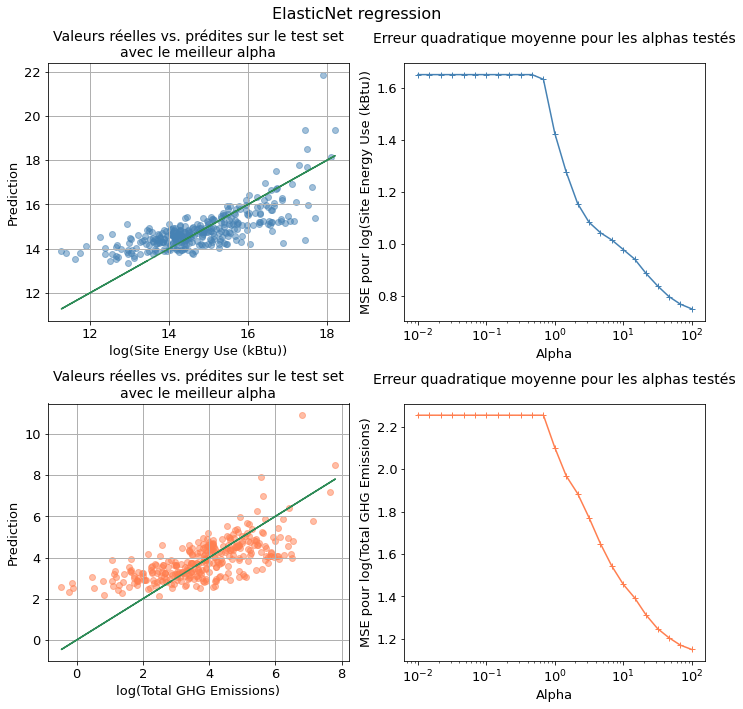

In [76]:
results_test = linearregression_cv(preprocessor, ElasticNetCV(alphas=alphas, n_jobs=-2, random_state=0), alphas, "ElasticNet regression", 
                              data_train, [targetSEUlog_train, targetGHGElog_train], 
                              data_test, [targetSEUlog_test, targetGHGElog_test], 
                              ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

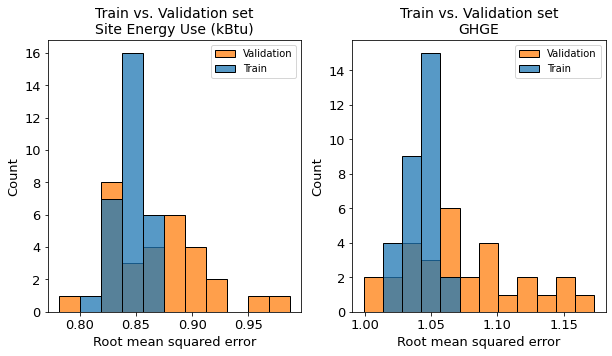

In [77]:
cv_results_SEU, cv_results_GHGE, model_SEU_05, model_GHGE_05 = custom_cv(preprocessor, ElasticNetCV(alphas=alphas, n_jobs=-2, random_state=0), ElasticNetCV(alphas=alphas, n_jobs=-2, random_state=0), "ElasticNet regression", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [78]:
model_SEU_05 = pd.concat([model_SEU_05[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_05 = pd.concat([model_GHGE_05[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [79]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_05])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516
0,ElasticNet regression,0.212,0.006,-0.639,-0.044,-0.714,-0.845,0.568,-0.655,-0.045,-0.759,-0.871,0.526


In [80]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_05])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441
0,ElasticNet regression,0.187,0.006,-0.792,-0.496,-1.087,-1.042,0.520,-0.819,-0.482,-1.120,-1.059,0.451


ElasticNet est un petit peu meilleur que lasso, mais reste légèrement en dessous de la régression ridge.

### Régression ridge avec feature engineering

On va tester une régression ridge avec transformation des données autorisant des équations polynomiales d'ordre 2, et en testant différentes valeurs de alpha.

In [81]:
alphas = np.logspace(-2, 5, num=25)

In [82]:
estimator = make_pipeline(PolynomialFeatures(degree=2), RidgeCV(alphas=alphas, store_cv_values=True))

log(Site Energy Use (kBtu))
Ridge best alpha: 31.623
Score : 0.63
MAE : 5.81e-01
RMSE : 7.69e-01
-----------------------------------------
log(Total GHG Emissions)
Ridge best alpha: 31.623
Score : 0.54
MAE : 7.50e-01
RMSE : 9.70e-01
-----------------------------------------


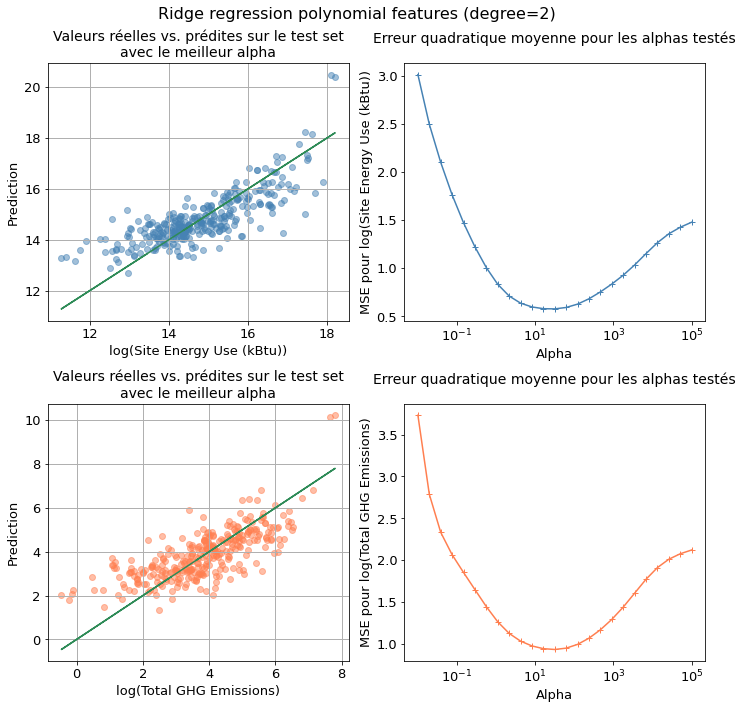

In [83]:
results_test = linearregression_cv(preprocessor, estimator, alphas, "Ridge regression polynomial features (degree=2)", 
                              data_train, [targetSEUlog_train, targetGHGElog_train], 
                              data_test, [targetSEUlog_test, targetGHGElog_test], 
                              ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"])

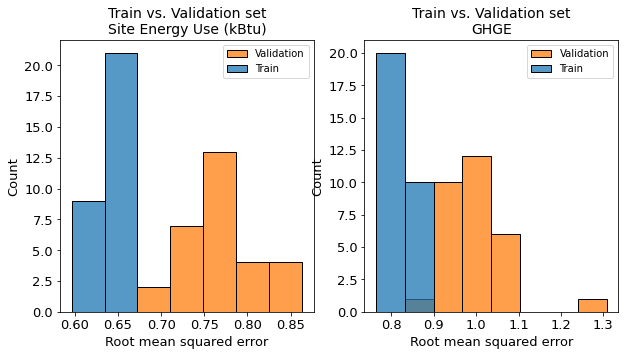

In [84]:
cv_results_SEU, cv_results_GHGE, model_SEU_06, model_GHGE_06 = custom_cv(preprocessor, estimator, estimator, "Ridge regression polynomial features degree=2", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [85]:
model_SEU_06 = pd.concat([model_SEU_06[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_06 = pd.concat([model_GHGE_06[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [86]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_06])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516
0,ElasticNet regression,0.212,0.006,-0.639,-0.044,-0.714,-0.845,0.568,-0.655,-0.045,-0.759,-0.871,0.526
0,Ridge regression polynomial features degree=2,0.598,0.008,-0.468,-0.032,-0.410,-0.640,0.752,-0.581,-0.040,-0.592,-0.769,0.631


In [87]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_06])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441
0,ElasticNet regression,0.187,0.006,-0.792,-0.496,-1.087,-1.042,0.520,-0.819,-0.482,-1.120,-1.059,0.451
0,Ridge regression polynomial features degree=2,0.616,0.009,-0.614,-0.405,-0.676,-0.822,0.701,-0.750,-0.426,-0.941,-0.970,0.539


Les performances du modèle augmentent significativement pour la consommation d'énergie, à la fois sur le train set (RMSE = 0.64 au lieu de 0.82 pour la régression ridge), et sur le test (RMSE = 0.77 au lieu de 0.86). Mais on commence à avoir une différence entre train et test set importante indiquant de l'overfitting.

De même, on constate une amélioration pour les émissions de gaz à effet de serre (RMSE train = 0.82 au lieu de 1.01 et RMSE test = 0.97 au lieu de 1.05). On est cependant dans l'overfitting aussi.

### Decision Tree simple

Passons aux arbres de décision avec un modèle simple à un seul arbre. On utilise un encodeur ordonné pour les variables catégorielles puisque cela n'impacte pas les performances du modèle et prend moins de temps de calcul.

In [88]:
cat_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
num_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([("cat_preprocessor", cat_preprocessor, cat_col),
                                 ("num_preprocessor", num_preprocessor, num_col)])

On va essayer d'optimiser la profondeur de l'arbre avec une grid search :

In [89]:
grid = {"decisiontreeregressor__max_depth": np.arange(1,20)}

Best params log(Site Energy Use (kBtu)): {'decisiontreeregressor__max_depth': 5}
Score : -0.81
MAE : 6.07e-01
RMSE : 8.15e-01
-----------------------------------------
Best params log(GHG Emissions): {'decisiontreeregressor__max_depth': 5}
Score : -1.01
MAE : 7.67e-01
RMSE : 1.01e+00
-----------------------------------------


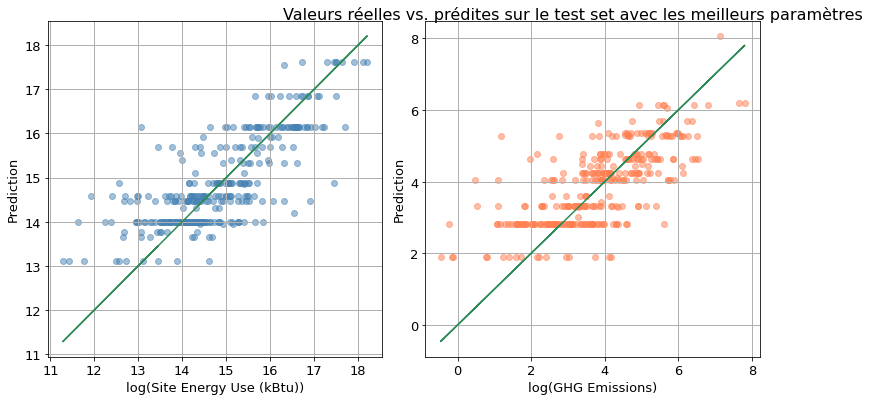

In [90]:
results = GS_eval(preprocessor, DecisionTreeRegressor(), "Decision Tree Regressor", 
                  data_train, [targetSEUlog_train, targetGHGElog_train], 
                  grid, scoring, "neg_root_mean_squared_error",
                  data_test, [targetSEUlog_test, targetGHGElog_test], ["log(Site Energy Use (kBtu))", "log(GHG Emissions)"])

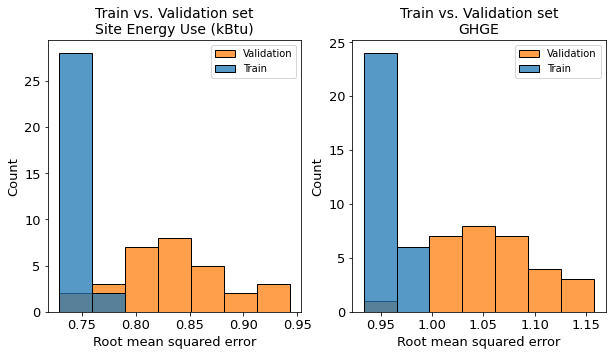

In [91]:
_, _, _, _ = custom_cv(preprocessor, DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=5), "Decision Tree Regressor", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [92]:
model_07_SEU = results["log(Site Energy Use (kBtu))"]
models_summary_SEU = pd.concat([models_summary_SEU, model_07_SEU])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516
0,ElasticNet regression,0.212,0.006,-0.639,-0.044,-0.714,-0.845,0.568,-0.655,-0.045,-0.759,-0.871,0.526
0,Ridge regression polynomial features degree=2,0.598,0.008,-0.468,-0.032,-0.410,-0.640,0.752,-0.581,-0.040,-0.592,-0.769,0.631
0,Decision Tree Regressor,0.009,0.005,-0.540,-0.037,-0.553,-0.744,0.668,-0.607,-0.042,-0.664,-0.815,0.585


In [93]:
model_07_GHGE = results["log(GHG Emissions)"]
models_summary_GHGE = pd.concat([models_summary_GHGE, model_07_GHGE])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441
0,ElasticNet regression,0.187,0.006,-0.792,-0.496,-1.087,-1.042,0.520,-0.819,-0.482,-1.120,-1.059,0.451
0,Ridge regression polynomial features degree=2,0.616,0.009,-0.614,-0.405,-0.676,-0.822,0.701,-0.750,-0.426,-0.941,-0.970,0.539
0,Decision Tree Regressor,0.009,0.004,-0.718,-0.444,-0.907,-0.952,0.600,-0.767,-0.444,-1.023,-1.011,0.498


La meilleure valeur de `max_depth` trouvée par la grid search est 5 pour les 2 targets.

Les résultats sur le test set très proches de la régression ridge avec feature engineering pour la consommation d'énergie, avec toujours une tendance à overfitting.

Les performances diminuent par contre pour la prédiction des émissions de gaz à effet de serre (RMSE passe de 0.97 à 1.01 sur le test set), mais avec une réduction de l'écart entre le train et test (moins d'overfitting).

On pourrait réduire la profondeur de l'arbre pour réduire l'overfitting, mais on va de suite passer à des modèles plus complexes qui ont plus de chances de faire de meilleures performances.

### Random Forest

En cherchant à optimiser les paramètres :

In [94]:
grid = {"randomforestregressor__n_estimators": [50, 100, 150, 200, 250],
        "randomforestregressor__max_depth": [5, 7, 9, 11],
        "randomforestregressor__max_features": [0.2, 0.4, 0.6, 0.8],
       "randomforestregressor__min_samples_leaf": [1, 5, 10, 15]}

Best params log(Site Energy Use (kBtu)): {'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 250}
Score : -0.70
MAE : 5.23e-01
RMSE : 7.01e-01
-----------------------------------------
Best params log(GHG Emissions): {'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 250}
Score : -0.92
MAE : 7.10e-01
RMSE : 9.16e-01
-----------------------------------------


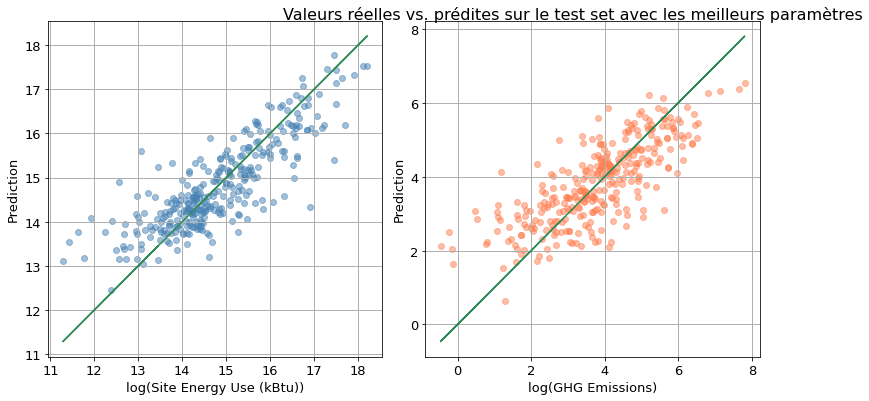

In [95]:
results = GS_eval(preprocessor, RandomForestRegressor(random_state=0), "Random Forest Regressor", 
                     data_train, [targetSEUlog_train, targetGHGElog_train], 
                     grid, scoring, "neg_root_mean_squared_error",
                     data_test, [targetSEUlog_test, targetGHGElog_test], 
                     ["log(Site Energy Use (kBtu))", "log(GHG Emissions)"])

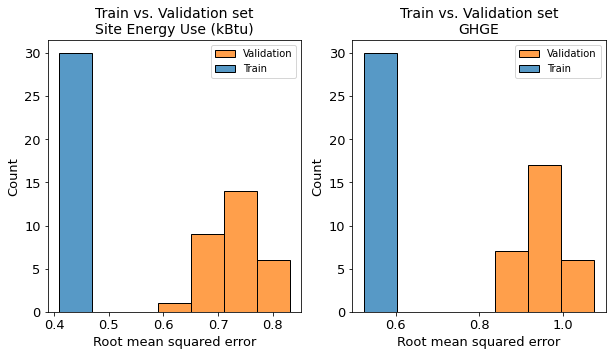

In [96]:
_, _, _, _ = custom_cv(preprocessor, RandomForestRegressor(max_depth=11, max_features=0.4, min_samples_leaf=1, n_estimators=250, random_state=0), RandomForestRegressor(max_depth=11, max_features=0.4, min_samples_leaf=1, n_estimators=250, random_state=0), "Random Forest optimised", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [97]:
results["log(Site Energy Use (kBtu))"]

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Random Forest Regressor,0.407,0.031,-0.310,-0.021,-0.180,-0.425,0.892,-0.523,-0.036,-0.491,-0.701,0.693


In [98]:
results["log(GHG Emissions)"]

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Random Forest Regressor,0.371,0.025,-0.411,-0.257,-0.290,-0.539,0.872,-0.710,-0.405,-0.838,-0.916,0.589


Le modèle overfit clairement avec les meilleurs hyperparamètres suggérés par la grid search : l'erreur est faible sur le train set mais beaucoup plus importante sur le test set. Le modèle généralise mal. On va réduire la profondeur de l'arbre et définir une valeur minimale de diminution de l'impureté pour éviter cela (en fixant `max_depth = 6` et `min_impurity_decrease=0.01`).

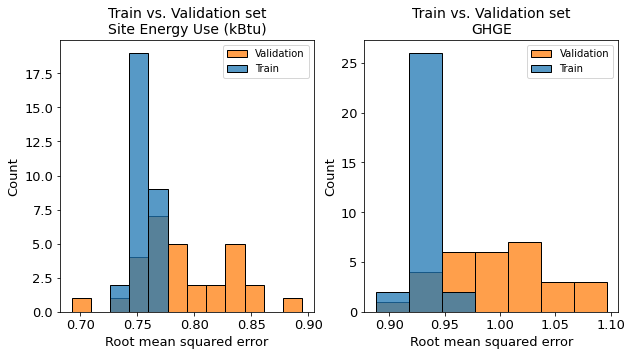

In [99]:
cv_results_SEU, cv_results_GHGE, model_SEU_09, model_GHGE_09 = custom_cv(preprocessor, RandomForestRegressor(max_depth=6, max_features=0.4, min_impurity_decrease=0.01, n_estimators=250, random_state=0), RandomForestRegressor(max_depth=6, max_features=0.4, min_impurity_decrease=0.01, n_estimators=250, random_state=0), "Random Forest optimised", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

On recalcule les metrics sur le test set :

In [100]:
results_test = {}

list_targets_train = [targetSEUlog_train, targetGHGElog_train]
list_targets_test = [targetSEUlog_test, targetGHGElog_test]
list_targets_names = ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"]

model = make_pipeline(preprocessor, RandomForestRegressor(max_depth=6, max_features=0.4, 
                                                          min_impurity_decrease=0.01, n_estimators=250,
                                                         random_state=0))

for target_train, target_test, target_name in zip(list_targets_train, list_targets_test, list_targets_names):
    model.fit(data_train, target_train)
    target_predicted = model.predict(data_test)

    # Get a few metrics on the test set:
    score = model.score(data_test, target_test)
    mae = mean_absolute_error(target_test, target_predicted)
    mape = mean_absolute_percentage_error(target_test, target_predicted)
    mse = mean_squared_error(target_test, target_predicted)
    rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
    r2 = r2_score(target_test, target_predicted)
    
    results_test[target_name] = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]],
                                  columns=["test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error",
                                          "test_neg_mean_squared_error", "test_neg_root_mean_squared_error", 
                                           "test_r2"])

In [101]:
model_SEU_09 = pd.concat([model_SEU_09[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_09 = pd.concat([model_GHGE_09[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [102]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_09])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516
0,ElasticNet regression,0.212,0.006,-0.639,-0.044,-0.714,-0.845,0.568,-0.655,-0.045,-0.759,-0.871,0.526
0,Ridge regression polynomial features degree=2,0.598,0.008,-0.468,-0.032,-0.410,-0.640,0.752,-0.581,-0.040,-0.592,-0.769,0.631
0,Decision Tree Regressor,0.009,0.005,-0.540,-0.037,-0.553,-0.744,0.668,-0.607,-0.042,-0.664,-0.815,0.585
0,Random Forest optimised,0.336,0.026,-0.556,-0.038,-0.571,-0.756,0.655,-0.561,-0.039,-0.575,-0.758,0.641


In [103]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_09])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441
0,ElasticNet regression,0.187,0.006,-0.792,-0.496,-1.087,-1.042,0.520,-0.819,-0.482,-1.120,-1.059,0.451
0,Ridge regression polynomial features degree=2,0.616,0.009,-0.614,-0.405,-0.676,-0.822,0.701,-0.750,-0.426,-0.941,-0.970,0.539
0,Decision Tree Regressor,0.009,0.004,-0.718,-0.444,-0.907,-0.952,0.600,-0.767,-0.444,-1.023,-1.011,0.498
0,Random Forest optimised,0.377,0.031,-0.723,-0.458,-0.875,-0.935,0.613,-0.757,-0.450,-0.933,-0.966,0.543


Les paramètres conservés pour l'algorithme Random Forest sont donc :
* `max_depth=6`
* `max_features=0.4`
* `min_impurity_decrease=0.01`
* `n_estimators=250`

Le modèle fait nettement mieux que les précédents : la RMSE descend à 0,76 pour la consommation, et 0,97 pour les émissions.

### Random Forest testé avec et sans energy star score

On teste une nouvelle fois l'effet de l'energy star score sur les prédictions, cette fois avec un modèle *random forest*.

#### AVEC energy star score

In [104]:
cat_col = data_ess.select_dtypes(include=["object"]).columns
num_col = data_ess.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Parking']


In [105]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

In [106]:
grid = {"randomforestregressor__n_estimators": [50, 100, 150, 200, 250],
        "randomforestregressor__max_depth": [5, 7, 9, 11],
        "randomforestregressor__max_features": [0.2, 0.4, 0.6, 0.8]}

Best params log(Site Energy Use (kBtu)): {'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.6, 'randomforestregressor__n_estimators': 200}
Score : -0.51
MAE : 3.57e-01
RMSE : 5.07e-01
-----------------------------------------
Best params log(GHG Emissions): {'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__n_estimators': 250}
Score : -0.85
MAE : 6.54e-01
RMSE : 8.49e-01
-----------------------------------------


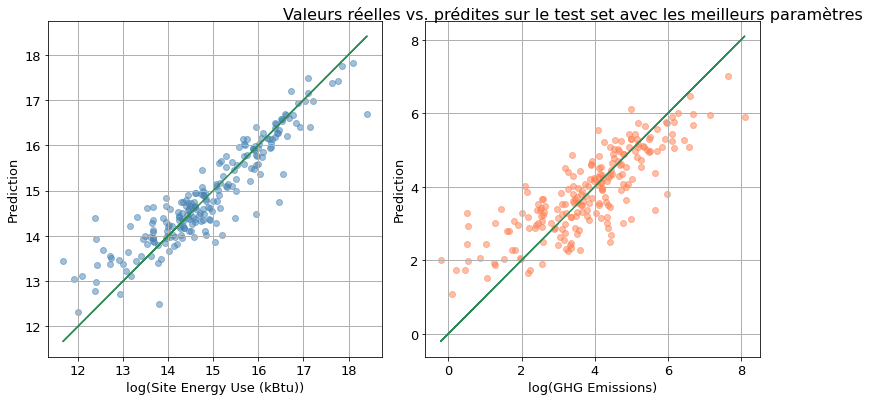

In [107]:
results = GS_eval(preprocessor, RandomForestRegressor(random_state=0), "Random Forest Regressor", 
                     data_ess_train, [targetSEUlog_ess_train, targetGHGElog_ess_train], 
                     grid, scoring, "neg_root_mean_squared_error",
                     data_ess_test, [targetSEUlog_ess_test, targetGHGElog_ess_test], 
                     ["log(Site Energy Use (kBtu))", "log(GHG Emissions)"])

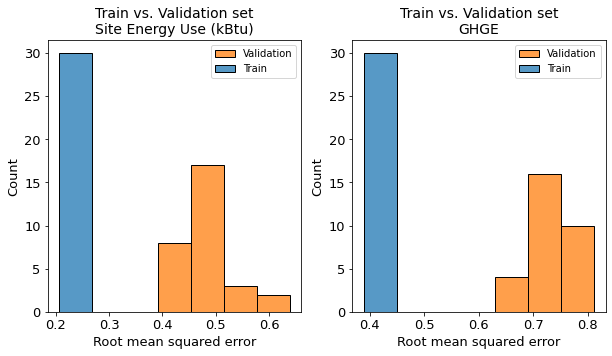

In [108]:
cv_results_SEU_ess, cv_results_GHGE_ess, model_SEU_ess_03, model_GHGE_ess_03 = custom_cv(preprocessor, RandomForestRegressor(max_depth=11, max_features=0.6, n_estimators=200, random_state=0), RandomForestRegressor(max_depth=11, max_features=0.4, n_estimators=250, random_state=0), "Random forest with ESS", data_ess_train , targetSEUlog_ess_train, targetGHGElog_ess_train, scoring)

On modifie les paramètres pour éviter l'overfitting :

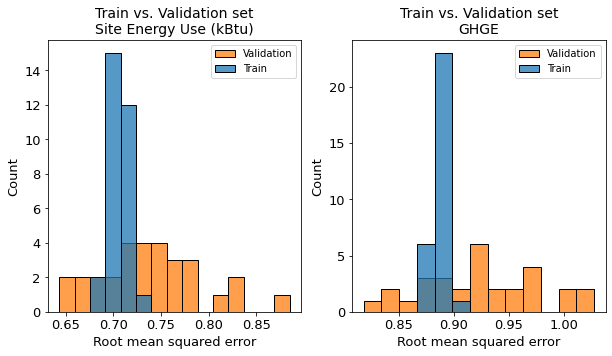

In [109]:
cv_results_SEU_ess, cv_results_GHGE_ess, model_SEU_ess_03, model_GHGE_ess_03 = custom_cv(preprocessor, RandomForestRegressor(max_depth=6, max_features=0.4, min_impurity_decrease=0.06, n_estimators=150, random_state=0), RandomForestRegressor(max_depth=6, max_features=0.4, min_impurity_decrease=0.06, n_estimators=200, random_state=0), "Random forest with ESS", data_ess_train , targetSEUlog_ess_train, targetGHGElog_ess_train, scoring)

On recalcul les résultats sur le test avec ces nouveau paramètres :

In [110]:
results_test = {}

list_targets_train = [targetSEUlog_ess_train, targetGHGElog_ess_train]
list_targets_test = [targetSEUlog_ess_test, targetGHGElog_ess_test]
list_targets_names = ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"]
estimators =[150, 200]

for esti, target_train, target_test, target_name in zip(estimators, list_targets_train, list_targets_test, 
                                                        list_targets_names):
    model = make_pipeline(preprocessor, RandomForestRegressor(max_depth=6, max_features=0.6, 
                                                              min_impurity_decrease=0.04, n_estimators=esti, 
                                                              random_state=0))
    model.fit(data_ess_train, target_train)
    target_predicted = model.predict(data_ess_test)

    # Get a few metrics on the test set:
    score = model.score(data_ess_test, target_test)
    mae = mean_absolute_error(target_test, target_predicted)
    mape = mean_absolute_percentage_error(target_test, target_predicted)
    mse = mean_squared_error(target_test, target_predicted)
    rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
    r2 = r2_score(target_test, target_predicted)
    
    results_test[target_name] = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]],
                                  columns=["test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error",
                                          "test_neg_mean_squared_error", "test_neg_root_mean_squared_error", 
                                           "test_r2"])

In [111]:
model_SEU_ess_03 = pd.concat([model_SEU_ess_03[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_ess_03 = pd.concat([model_GHGE_ess_03[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [112]:
model_SEU_ess = pd.concat([model_SEU_ess, model_SEU_ess_03])
model_SEU_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.104,0.010,-0.468,-0.032,-0.381,-0.617,0.748,-0.532,-0.037,-0.479,-0.692,0.702
0,Ridge regression without ESS,0.075,0.006,-0.533,-0.036,-0.496,-0.704,0.672,-0.584,-0.040,-0.603,-0.776,0.625
0,Random forest with ESS,0.164,0.014,-0.528,-0.036,-0.499,-0.706,0.665,-0.542,-0.038,-0.553,-0.744,0.656


In [113]:
model_GHGE_ess = pd.concat([model_GHGE_ess, model_GHGE_ess_03])
model_GHGE_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.085,0.006,-0.662,-0.375,-0.726,-0.852,0.639,-0.757,-0.518,-0.964,-0.982,0.559
0,Ridge regression without ESS,0.076,0.005,-0.707,-0.422,-0.842,-0.917,0.581,-0.822,-0.575,-1.150,-1.072,0.473
0,Random forest with ESS,0.225,0.018,-0.701,-0.419,-0.790,-0.889,0.598,-0.809,-0.536,-1.098,-1.048,0.497


Paramètres finaux :
* `max_depth = 6`
* `max_features = 0.4`
* `min_impurity_decrease = 0.06`
* `n_estimators = 150` pour la consommation d'énergie, `n_estimators = 200` pour les émissions

#### SANS energy star score

In [114]:
cat_col = data_no_ess_train.select_dtypes(include=["object"]).columns
num_col = data_no_ess_train.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'Parking']


In [115]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

Best params log(Site Energy Use (kBtu)): {'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__n_estimators': 250}
Score : -0.66
MAE : 4.55e-01
RMSE : 6.58e-01
-----------------------------------------
Best params log(GHG Emissions): {'randomforestregressor__max_depth': 9, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__n_estimators': 250}
Score : -0.98
MAE : 7.27e-01
RMSE : 9.78e-01
-----------------------------------------


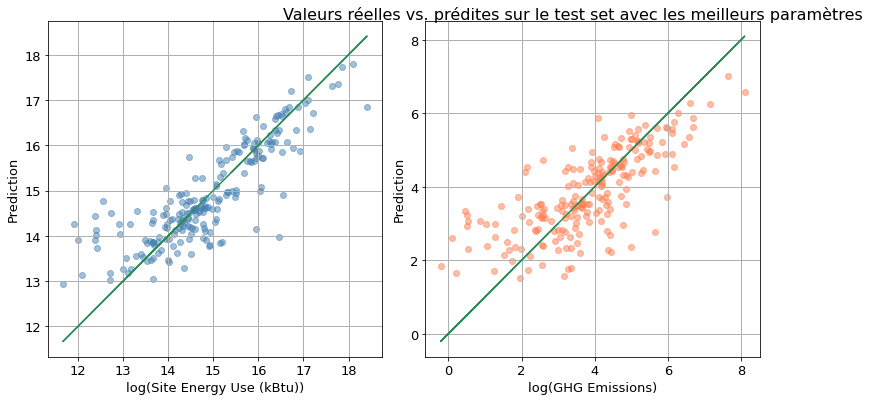

In [116]:
results = GS_eval(preprocessor, RandomForestRegressor(random_state=0), "Random Forest without ESS", 
                     data_no_ess_train, [targetSEUlog_ess_train, targetGHGElog_ess_train], 
                     grid, scoring, "neg_root_mean_squared_error",
                     data_no_ess_test, [targetSEUlog_ess_test, targetGHGElog_ess_test], 
                     ["log(Site Energy Use (kBtu))", "log(GHG Emissions)"])

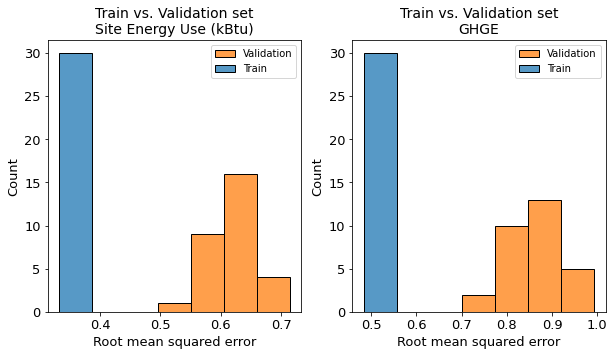

In [117]:
cv_results_SEU_ess, cv_results_GHGE_ess, model_SEU_ess_04, model_GHGE_ess_04 = custom_cv(preprocessor, RandomForestRegressor(max_depth=11, max_features=0.4, n_estimators=250, random_state=0), RandomForestRegressor(max_depth=11, max_features=0.4, n_estimators=250, random_state=0), "Random forest without ESS", data_no_ess , targetSEUlog_ess, targetGHGElog_ess, scoring)

Encore une fois, on réduit l'overfitting :

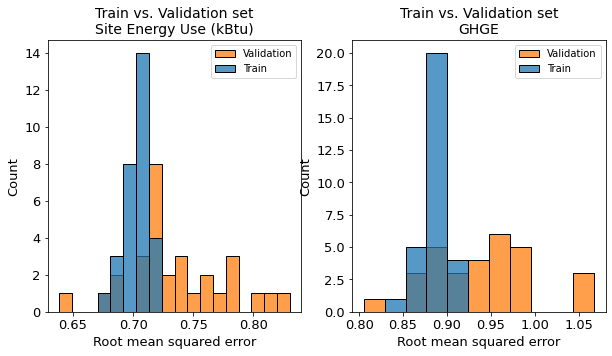

In [118]:
cv_results_SEU_ess, cv_results_GHGE_ess, model_SEU_ess_04, model_GHGE_ess_04 = custom_cv(preprocessor, RandomForestRegressor(max_depth=7, max_features=0.4, min_impurity_decrease=0.04, n_estimators=200, random_state=42), RandomForestRegressor(max_depth=7, max_features=0.6, min_impurity_decrease=0.04, n_estimators=200, random_state=42), "Random forest without ESS", data_no_ess , targetSEUlog_ess, targetGHGElog_ess, scoring)

In [119]:
results_test = {}

list_targets_train = [targetSEUlog_ess_train, targetGHGElog_ess_train]
list_targets_test = [targetSEUlog_ess_test, targetGHGElog_ess_test]
list_targets_names = ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"]
mfeatures = [0.4, 0.6]

for mf, target_train, target_test, target_name in zip(mfeatures, list_targets_train, 
                                                           list_targets_test, list_targets_names):
    
    model = make_pipeline(preprocessor, RandomForestRegressor(max_depth=7, max_features=mf, 
                                                              min_impurity_decrease=0.04, n_estimators=200, 
                                                              random_state=0))
    model.fit(data_no_ess_train, target_train)
    target_predicted = model.predict(data_no_ess_test)

    # Get a few metrics on the test set:
    score = model.score(data_no_ess_test, target_test)
    mae = mean_absolute_error(target_test, target_predicted)
    mape = mean_absolute_percentage_error(target_test, target_predicted)
    mse = mean_squared_error(target_test, target_predicted)
    rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
    r2 = r2_score(target_test, target_predicted)
    
    results_test[target_name] = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]],
                                  columns=["test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error",
                                          "test_neg_mean_squared_error", "test_neg_root_mean_squared_error", 
                                           "test_r2"])

In [120]:
model_SEU_ess_04 = pd.concat([model_SEU_ess_04[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_ess_04 = pd.concat([model_GHGE_ess_04[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [121]:
model_SEU_ess = pd.concat([model_SEU_ess, model_SEU_ess_04])
model_SEU_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.104,0.010,-0.468,-0.032,-0.381,-0.617,0.748,-0.532,-0.037,-0.479,-0.692,0.702
0,Ridge regression without ESS,0.075,0.006,-0.533,-0.036,-0.496,-0.704,0.672,-0.584,-0.040,-0.603,-0.776,0.625
0,Random forest with ESS,0.164,0.014,-0.528,-0.036,-0.499,-0.706,0.665,-0.542,-0.038,-0.553,-0.744,0.656
0,Random forest without ESS,0.247,0.019,-0.519,-0.035,-0.494,-0.703,0.673,-0.555,-0.039,-0.600,-0.775,0.626


In [122]:
model_GHGE_ess = pd.concat([model_GHGE_ess, model_GHGE_ess_04])
model_GHGE_ess

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Ridge regression with ESS,0.085,0.006,-0.662,-0.375,-0.726,-0.852,0.639,-0.757,-0.518,-0.964,-0.982,0.559
0,Ridge regression without ESS,0.076,0.005,-0.707,-0.422,-0.842,-0.917,0.581,-0.822,-0.575,-1.150,-1.072,0.473
0,Random forest with ESS,0.225,0.018,-0.701,-0.419,-0.790,-0.889,0.598,-0.809,-0.536,-1.098,-1.048,0.497
0,Random forest without ESS,0.301,0.020,-0.694,-0.422,-0.785,-0.886,0.609,-0.830,-0.560,-1.154,-1.074,0.471


Paramètres finaux :
* `max_depth = 7`
* `max_features = 0.4` pour la consommation d'énergie, `max_features = 0.6` pour les émissions
* `min_impurity_decrease = 0.04`
* `n_estimators = 200`

L'énergy star score n'améliore que très peu les résultats : en l'ajoutant, on passe d'une RMSE de 0.775 à 0.744 pour la prédiction de la consommation d'énergie et 1.074 à 1.048 pour les émissions.
Dans la mesure où cette variable est difficile à obtenir, on ne recommandera pas son utilisation.

### Gradient Boosting Regressor

Passons aux modèles de boosting.

In [123]:
cat_col = data.select_dtypes(include=["object"]).columns
num_col = data.select_dtypes(exclude=["object"]).columns

print(f"Variables catégorielles : \n{list(cat_col)}")
print("==============================================")
print(f"Variables numériques :\n{list(num_col)}")

Variables catégorielles : 
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MainEnergyUse']
Variables numériques :
['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'Parking']


In [124]:
preprocessor = ColumnTransformer([("num_preprocessor", StandardScaler(), num_col),
                                 ("cat_preprocessor", OneHotEncoder(handle_unknown="ignore"), cat_col)])

In [125]:
grid = {"gradientboostingregressor__n_estimators": [50, 100, 150, 200, 250],
        "gradientboostingregressor__max_depth": [3, 5, 7, 9, 11],
        "gradientboostingregressor__max_features": [0.2, 0.4, 0.6, 0.8],
        "gradientboostingregressor__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
       "gradientboostingregressor__subsample": [0.2, 0.4, 0.6, 0.8, 1]}

Best params log(Site Energy Use (kBtu)): {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__max_features': 0.2, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__subsample': 0.6}
Score : -0.68
MAE : 5.19e-01
RMSE : 6.83e-01
-----------------------------------------
Best params log(GHG Emissions): {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__max_features': 0.2, 'gradientboostingregressor__n_estimators': 150, 'gradientboostingregressor__subsample': 0.8}
Score : -0.90
MAE : 7.07e-01
RMSE : 8.98e-01
-----------------------------------------


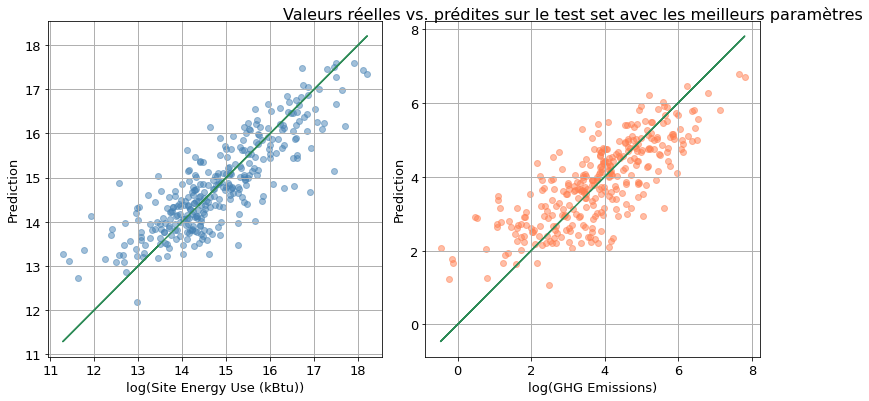

In [126]:
results = GS_eval(preprocessor, GradientBoostingRegressor(random_state=0),
                  "Gradient Boosting Regressor optimised", 
                     data_train, [targetSEUlog_train, targetGHGElog_train], 
                     grid, scoring, "neg_root_mean_squared_error",
                     data_test, [targetSEUlog_test, targetGHGElog_test], 
                     ["log(Site Energy Use (kBtu))", "log(GHG Emissions)"])

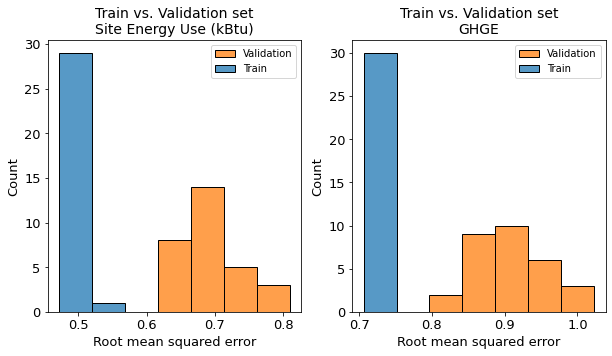

In [127]:
cv_results_SEU, cv_results_GHGE, model_SEU_10, model_GHGE_10 = custom_cv(preprocessor, GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features=0.4, subsample=0.6, n_estimators=250, random_state=0), GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features=0.4, n_estimators=150, subsample=0.8, random_state=0), "Gradient Boosting Regressor optimised", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

Comme pour l'algorithme *random forest*, on fait de l'overfit, avec des scores sur le test trop faibles par rapport au train. En fixant manuellement certains paramètres (`min_sample_leaf`, `subsample`), on réduit significativement l'overfit.

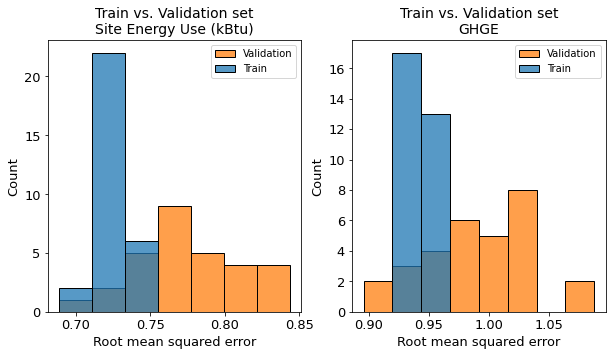

In [128]:
cv_results_SEU, cv_results_GHGE, model_SEU_10, model_GHGE_10 = custom_cv(preprocessor, GradientBoostingRegressor(learning_rate=0.04, max_depth=3, max_features=0.4, min_samples_leaf=30, subsample=0.6, n_estimators=250, random_state=0), GradientBoostingRegressor(learning_rate=0.04, max_depth=3, max_features=0.4, min_samples_leaf=30, subsample=0.8, n_estimators=150, random_state=0), "Gradient Boosting Regressor optimised", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

On refait une évaluation avec ces paramètressur le test set :

In [129]:
results_test = {}

list_targets_train = [targetSEUlog_train, targetGHGElog_train]
list_targets_test = [targetSEUlog_test, targetGHGElog_test]
list_targets_names = ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"]
subsample_values = [0.8, 1]

for subsample, target_train, target_test, target_name in zip(subsample_values, list_targets_train, 
                                                             list_targets_test, list_targets_names):
    model = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=0.04, max_depth=3, 
                                                                  max_features=0.4, min_samples_leaf=30, 
                                                                  subsample=0.8, n_estimators=250,
                                                                 random_state=0))
    model.fit(data_train, target_train)
    target_predicted = model.predict(data_test)

    # Get a few metrics on the test set:
    score = model.score(data_test, target_test)
    mae = mean_absolute_error(target_test, target_predicted)
    mape = mean_absolute_percentage_error(target_test, target_predicted)
    mse = mean_squared_error(target_test, target_predicted)
    rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
    r2 = r2_score(target_test, target_predicted)
    
    results_test[target_name] = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]],
                                  columns=["test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error",
                                          "test_neg_mean_squared_error", "test_neg_root_mean_squared_error", 
                                           "test_r2"])

In [130]:
model_SEU_10 = pd.concat([model_SEU_10[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_10 = pd.concat([model_GHGE_10[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [131]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_10])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516
0,ElasticNet regression,0.212,0.006,-0.639,-0.044,-0.714,-0.845,0.568,-0.655,-0.045,-0.759,-0.871,0.526
0,Ridge regression polynomial features degree=2,0.598,0.008,-0.468,-0.032,-0.410,-0.640,0.752,-0.581,-0.040,-0.592,-0.769,0.631
0,Decision Tree Regressor,0.009,0.005,-0.540,-0.037,-0.553,-0.744,0.668,-0.607,-0.042,-0.664,-0.815,0.585
0,Random Forest optimised,0.336,0.026,-0.556,-0.038,-0.571,-0.756,0.655,-0.561,-0.039,-0.575,-0.758,0.641
0,Gradient Boosting Regressor optimised,0.176,0.007,-0.527,-0.036,-0.524,-0.724,0.683,-0.539,-0.037,-0.533,-0.730,0.667


In [132]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_10])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441
0,ElasticNet regression,0.187,0.006,-0.792,-0.496,-1.087,-1.042,0.520,-0.819,-0.482,-1.120,-1.059,0.451
0,Ridge regression polynomial features degree=2,0.616,0.009,-0.614,-0.405,-0.676,-0.822,0.701,-0.750,-0.426,-0.941,-0.970,0.539
0,Decision Tree Regressor,0.009,0.004,-0.718,-0.444,-0.907,-0.952,0.600,-0.767,-0.444,-1.023,-1.011,0.498
0,Random Forest optimised,0.377,0.031,-0.723,-0.458,-0.875,-0.935,0.613,-0.757,-0.450,-0.933,-0.966,0.543
0,Gradient Boosting Regressor optimised,0.109,0.006,-0.717,-0.451,-0.889,-0.943,0.607,-0.733,-0.416,-0.887,-0.942,0.565


Les meilleurs paramètres pour le *gradient boosting* qui optimisent le score sans overfit :
* `learning_rate=0.04`
* `max_depth=3`
* `max_features=0.4`
* `min_samples_leaf=30`
* `n_estimators=250` pour `log(SiteEnergyUse(kBtu))` et `n_estimators=150` pour `log(TotalGHGEmissions)`
* `subsample=0.6` pour `log(SiteEnergyUse(kBtu))` et `subsample=0.8` pour `log(TotalGHGEmissions)`

On observe encore une fois une nette diminution de l'erreur par rapport au modèle *random forest*.

On va jetter un coup d'oeil sur l'importance relative des variables pour la prédiction.

In [134]:
data_train.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,LargestPropertyUseTypeGFA,MainEnergyUse,Parking
728,NonResidential,Retail Store,GREATER DUWAMISH,1953,1.000,1.000,Retail Store,25000.000,NaturalGas,False
48,NonResidential,Hotel,LAKE UNION,1959,1.000,5.000,Hotel,70627.000,Electricity,True
644,NonResidential,Other,DOWNTOWN,1955,1.000,2.000,Financial Office,31160.000,Electricity,False
615,SPS-District K-12,K-12 School,NORTHWEST,1930,1.000,2.000,K-12 School,46066.000,NaturalGas,False
757,NonResidential,Other,GREATER DUWAMISH,1976,1.000,1.000,Manufacturing/Industrial Plant,45320.000,NaturalGas,False


In [161]:
#features = np.append(cat_col, num_col)

#model = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=0.04, max_depth=3, max_features=0.4, 
#                                                              min_samples_leaf=30, subsample=0.6, n_estimators=250,
#                                                              random_state=0))
#model.fit(data_train, targetSEUlog_train)
#importances = model.named_steps["gradientboostingregressor"].feature_importances_
#poids_features_SEU = pd.DataFrame({"Variables":features, "Importance":importances}).sort_values(by="Importance", ascending = False)

#model = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=0.04, max_depth=3, max_features=0.4, 
#                                                              min_samples_leaf=30, subsample=0.6, n_estimators=150,
#                                                             random_state=0))
#model.fit(data_train, targetGHGElog_train)
#importances = model.named_steps["gradientboostingregressor"].feature_importances_
#poids_features_GHGE = pd.DataFrame({"Variables":features, "Importance":importances}).sort_values(by="Importance", ascending = False)

In [162]:
#fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
#fig.suptitle("Importance des variables dans le modèle gradient boosting")

#liste_df = [poids_features_SEU, poids_features_GHGE]
#titres = ["Prédiction de 'Site Energy Use (kBtu)'", "Prédiction de 'Total GHG Emissions'"]
#colors = ["steelblue", "coral"]
#axes = [0, 1]

#for axe, df, ti, colo, axe in zip (axes, liste_df, titres, colors, axes):
#    ax[axe].bar(df["Variables"], df["Importance"], color=colo, zorder=3)
#    ax[axe].set_xticks(df["Variables"])
#    ax[axe].set_xticklabels(df["Variables"], rotation=45, ha="right")
#    ax[axe].set_title(ti)
#    ax[axe].set_ylabel("Importance")
#    ax[axe].grid(axis="y");

#fig.savefig("features_importance_gradientboosting.png", bbox_inches="tight", dpi=150);

La variable la plus importante est donc la surface dédiée à l'usage principal pour les 2 targets. Pour la consommation d'énergie, la 2e variable la plus importante est le principal type d'usage du bâtiment alors qu'il s'agit de la principale source d'énergie pour les émissions de gaz à effet de serre. Le classement des autres variables est ensuite la même pour les 2 targets.

### XGBoost

Comme toujours, on cherche à optimiser les hyperparamètres.

In [163]:
grid = {"xgbregressor__n_estimators": [50, 100, 150, 200, 250],
        "xgbregressor__max_depth": [3, 4, 5, 8],
        "xgbregressor__subsample": [0.2, 0.4, 0.6, 0.8],
        "xgbregressor__colsample_bynode": [0.2, 0.4, 0.6, 0.8, 1],
       "xgbregressor__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3]}

Best params log(Site Energy Use (kBtu)): {'xgbregressor__colsample_bynode': 0.2, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 150, 'xgbregressor__subsample': 0.8}
Score : -0.68
MAE : 5.15e-01
RMSE : 6.79e-01
-----------------------------------------
Best params log(GHG Emissions): {'xgbregressor__colsample_bynode': 0.2, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 150, 'xgbregressor__subsample': 0.8}
Score : -0.90
MAE : 6.95e-01
RMSE : 9.00e-01
-----------------------------------------


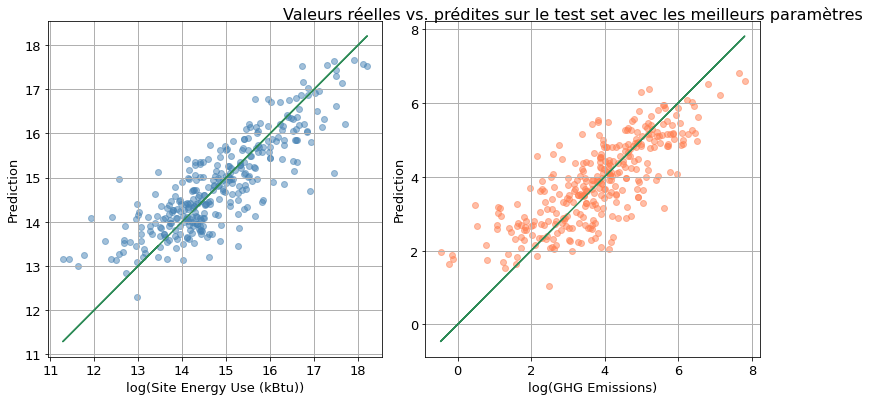

In [164]:
results = GS_eval(preprocessor, XGBRegressor(booster="gbtree", random_state=0), "XGBoost regressor optimised", data_train, [targetSEUlog_train, targetGHGElog_train], grid, scoring, 
        "neg_root_mean_squared_error", data_test, [targetSEUlog_test, targetGHGElog_test], ["log(Site Energy Use (kBtu))", "log(GHG Emissions)"])

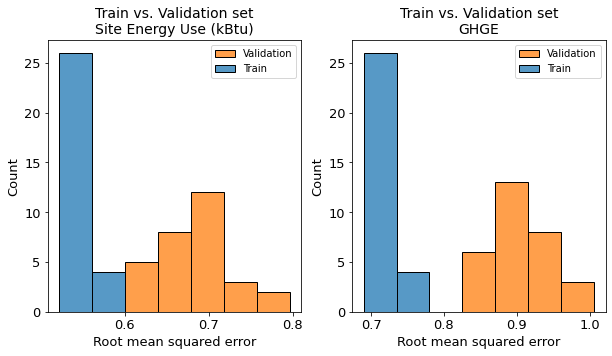

In [165]:
cv_results_SEU, cv_results_GHGE, model_SEU_11, model_GHGE_11 = custom_cv(preprocessor, XGBRegressor(colsample_bynode=0.4, max_depth=3, learning_rate=0.1, n_estimators=200, subsample=0.6, random_state=0), XGBRegressor(colsample_bynode=0.2, max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.8, random_state=0), "XGB Regressor optimised", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

Toujours un peu d'overfitting ici. En rajoutant un paramètre de régularisation (`alpha`) :

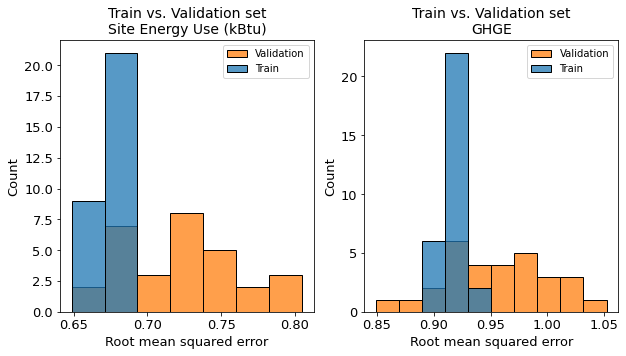

In [166]:
cv_results_SEU, cv_results_GHGE, model_SEU_11, model_GHGE_11 = custom_cv(preprocessor, XGBRegressor(colsample_bynode=0.4, max_depth=3, learning_rate=0.1, n_estimators=200, subsample=0.6, alpha=10, random_state=0), XGBRegressor(colsample_bynode=0.2, max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.8, alpha=20, random_state=0), "XGB Regressor optimised", data_train, targetSEUlog_train, targetGHGElog_train, scoring)

In [167]:
results_test = {}

list_targets_train = [targetSEUlog_train, targetGHGElog_train]
list_targets_test = [targetSEUlog_test, targetGHGElog_test]
list_targets_names = ["log(Site Energy Use (kBtu))", "log(Total GHG Emissions)"]
colsample_values = [0.4, 0.2]
subsample_values = [0.6, 0.8]
estimators = [200, 250]
alpahs = [10, 20]


for colsample, subsample, al, esti, target_train, target_test, target_name in zip(colsample_values, 
                                                            subsample_values, alpahs, 
                                                            estimators, list_targets_train, 
                                                             list_targets_test, list_targets_names):
    model = make_pipeline(preprocessor, XGBRegressor(learning_rate=0.1, max_depth=3, 
                                                                  colsample_bynode=colsample, alpha=al, 
                                                                  subsample=subsample, n_estimators=esti,
                                                                 random_state=0))
    model.fit(data_train, target_train)
    target_predicted = model.predict(data_test)

    # Get a few metrics on the test set:
    score = model.score(data_test, target_test)
    mae = mean_absolute_error(target_test, target_predicted)
    mape = mean_absolute_percentage_error(target_test, target_predicted)
    mse = mean_squared_error(target_test, target_predicted)
    rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
    r2 = r2_score(target_test, target_predicted)
    
    results_test[target_name] = pd.DataFrame([[-mae, -mape, -mse, -rmse, r2]],
                                  columns=["test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error",
                                          "test_neg_mean_squared_error", "test_neg_root_mean_squared_error", 
                                           "test_r2"])

In [168]:
model_SEU_11 = pd.concat([model_SEU_11[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Site Energy Use (kBtu))"]], axis=1)
model_GHGE_11 = pd.concat([model_GHGE_11[["model_name", "fit_time", "score_time", "train_neg_mean_absolute_error", 
                                        "train_neg_mean_absolute_percentage_error", "train_neg_mean_squared_error",
                                        "train_neg_root_mean_squared_error", "train_r2"]], 
                          results_test["log(Total GHG Emissions)"]], axis=1)

In [169]:
models_summary_SEU = pd.concat([models_summary_SEU, model_SEU_11])
models_summary_SEU

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,-1.024,-0.069,-1.654,-1.286,0.000,-1.020,-0.069,-1.621,-1.272,-0.005
0,Linear regression num only,0.006,0.002,-0.759,-0.052,-0.984,-0.992,0.405,-0.764,-0.052,-1.017,-1.008,0.369
0,Linear regression num and cat,0.024,0.006,-0.584,-0.040,-0.623,-0.789,0.624,-0.643,-0.044,-0.754,-0.867,0.532
0,Ridge regression,0.081,0.006,-0.601,-0.041,-0.644,-0.802,0.611,-0.653,-0.045,-0.742,-0.862,0.536
0,Lasso regression,0.168,0.006,-0.654,-0.045,-0.744,-0.862,0.550,-0.663,-0.045,-0.774,-0.880,0.516
0,ElasticNet regression,0.212,0.006,-0.639,-0.044,-0.714,-0.845,0.568,-0.655,-0.045,-0.759,-0.871,0.526
0,Ridge regression polynomial features degree=2,0.598,0.008,-0.468,-0.032,-0.410,-0.640,0.752,-0.581,-0.040,-0.592,-0.769,0.631
0,Decision Tree Regressor,0.009,0.005,-0.540,-0.037,-0.553,-0.744,0.668,-0.607,-0.042,-0.664,-0.815,0.585
0,Random Forest optimised,0.336,0.026,-0.556,-0.038,-0.571,-0.756,0.655,-0.561,-0.039,-0.575,-0.758,0.641
0,Gradient Boosting Regressor optimised,0.176,0.007,-0.527,-0.036,-0.524,-0.724,0.683,-0.539,-0.037,-0.533,-0.730,0.667


In [170]:
models_summary_GHGE = pd.concat([models_summary_GHGE, model_GHGE_11])
models_summary_GHGE

,model_name,fit_time,score_time,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,train_neg_root_mean_squared_error,train_r2,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,-1.178,-0.718,-2.263,-1.504,0.000,-1.169,-0.688,-2.211,-1.486,-0.004
0,Linear regression num only,0.005,0.003,-1.023,-0.637,-1.733,-1.316,0.234,-1.026,-0.612,-1.755,-1.324,0.202
0,Linear regression num and cat,0.024,0.005,-0.743,-0.458,-0.978,-0.989,0.568,-0.819,-0.474,-1.176,-1.084,0.464
0,Ridge regression,0.081,0.008,-0.764,-0.474,-1.014,-1.007,0.552,-0.812,-0.465,-1.107,-1.052,0.457
0,Lasso regression,0.139,0.005,-0.804,-0.503,-1.120,-1.058,0.505,-0.828,-0.487,-1.140,-1.068,0.441
0,ElasticNet regression,0.187,0.006,-0.792,-0.496,-1.087,-1.042,0.520,-0.819,-0.482,-1.120,-1.059,0.451
0,Ridge regression polynomial features degree=2,0.616,0.009,-0.614,-0.405,-0.676,-0.822,0.701,-0.750,-0.426,-0.941,-0.970,0.539
0,Decision Tree Regressor,0.009,0.004,-0.718,-0.444,-0.907,-0.952,0.600,-0.767,-0.444,-1.023,-1.011,0.498
0,Random Forest optimised,0.377,0.031,-0.723,-0.458,-0.875,-0.935,0.613,-0.757,-0.450,-0.933,-0.966,0.543
0,Gradient Boosting Regressor optimised,0.109,0.006,-0.717,-0.451,-0.889,-0.943,0.607,-0.733,-0.416,-0.887,-0.942,0.565


Les meilleurs paramètres sans tomber dans l'overfitting :

Paramètres | consommation | émissions
-----------|--------------|----------
colsample_bynode | 0.4 | 0.2
max_depth | 3 | 3
learning_rate | 0.1 | 0.1
n_estimators | 200 | 250
subsample | 0.6 | 0.8
alpha | 10 | 20

Les résultats sont très proches de ceux du *gradient boosting* mais légèrement moins bons.

Sur l'importance des variables :

In [172]:
#model = make_pipeline(preprocessor, XGBRegressor(colsample_bynode=0.4, max_depth=3, learning_rate=0.1, 
#                                                    n_estimators=200, subsample=0.6, alpha=10, random_state=0))
#model.fit(data_train, targetSEUlog_train)
#importances = model.named_steps["xgbregressor"].feature_importances_
#poids_features_SEU = pd.DataFrame({"Variables":features, "Importance":importances}).sort_values(by="Importance", ascending = False)
#
#model = make_pipeline(preprocessor, XGBRegressor(colsample_bynode=0.2, max_depth=3, n_estimators=250, 
#                                                              learning_rate=0.1, subsample=0.8, alpha=20, 
#                                                              random_state=0))
#model.fit(data_train, targetGHGElog_train)
#importances = model.named_steps["xgbregressor"].feature_importances_
#poids_features_GHGE = pd.DataFrame({"Variables":features, "Importance":importances}).sort_values(by="Importance", ascending = False)

In [173]:
#fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
#fig.suptitle("Importance des variables dans le modèle XGB Regressor")

#liste_df = [poids_features_SEU, poids_features_GHGE]
#titres = ["Prédiction de 'Site Energy Use (kBtu)'", "Prédiction de 'Total GHG Emissions'"]
#colors = ["steelblue", "coral"]
#axes = [0, 1]

#for axe, df, ti, colo, axe in zip (axes, liste_df, titres, colors, axes):
#    ax[axe].bar(df["Variables"], df["Importance"], color=colo, zorder=3)
#    ax[axe].set_xticks(df["Variables"])
#    ax[axe].set_xticklabels(df["Variables"], rotation=45, ha="right")
#    ax[axe].set_title(ti)
#    ax[axe].set_ylabel("Importance")
#    ax[axe].grid(axis="y");

#fig.savefig("features_importance_xgbr.png", bbox_inches="tight", dpi=150);

L'ordre d'importance des features change légèrement par rapport au *gradient boosting* : la source d'énergie principale devient la 3e variable la plus importante pour la prédiction de la consommation, et son importance relatice augmente pour la prédiction des émissions. Le nombre d'étages redescend dans le classement.

## Comparaison des résultats des différents modèles

In [174]:
# On remet les valeurs en positif pour plus de lisibilité

for df in [models_summary_SEU, models_summary_GHGE]:
    df[["train_neg_mean_absolute_error", "train_neg_mean_absolute_percentage_error", 
                    "train_neg_mean_squared_error", "train_neg_root_mean_squared_error", 
                    "test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error", 
                    "test_neg_mean_squared_error", 
                    "test_neg_root_mean_squared_error"]] = -df[["train_neg_mean_absolute_error", 
                    "train_neg_mean_absolute_percentage_error", 
                    "train_neg_mean_squared_error", "train_neg_root_mean_squared_error", 
                    "test_neg_mean_absolute_error", "test_neg_mean_absolute_percentage_error", 
                    "test_neg_mean_squared_error", "test_neg_root_mean_squared_error"]]
    df.rename(columns={"train_neg_mean_absolute_error":"train_mean_absolute_error", 
                       "train_neg_mean_absolute_percentage_error":"train_mean_absolute_percentage_error",
                       "train_neg_mean_squared_error":"train_mean_squared_error",
                       "train_neg_root_mean_squared_error":"train_root_mean_squared_error",
                       "test_neg_mean_absolute_error":"test_mean_absolute_error",
                       "test_neg_mean_absolute_percentage_error":"test_mean_absolute_percentage_error",
                       "test_neg_mean_squared_error":"test_mean_squared_error",
                       "test_neg_root_mean_squared_error":"test_root_mean_squared_error"}, inplace=True)

Les résultats sur les temps de fit/score et les différentes metrics (sur train et test set) sont les suivants :

**Prédiction de la consommation totale d'énergie**

In [175]:
models_summary_SEU

,model_name,fit_time,score_time,train_mean_absolute_error,train_mean_absolute_percentage_error,train_mean_squared_error,train_root_mean_squared_error,train_r2,test_mean_absolute_error,test_mean_absolute_percentage_error,test_mean_squared_error,test_root_mean_squared_error,test_r2
0,Dummy Regressor,0.010,0.004,1.024,0.069,1.654,1.286,0.000,1.020,0.069,1.621,1.272,-0.005
0,Linear regression num only,0.006,0.002,0.759,0.052,0.984,0.992,0.405,0.764,0.052,1.017,1.008,0.369
0,Linear regression num and cat,0.024,0.006,0.584,0.040,0.623,0.789,0.624,0.643,0.044,0.754,0.867,0.532
0,Ridge regression,0.081,0.006,0.601,0.041,0.644,0.802,0.611,0.653,0.045,0.742,0.862,0.536
0,Lasso regression,0.168,0.006,0.654,0.045,0.744,0.862,0.550,0.663,0.045,0.774,0.880,0.516
0,ElasticNet regression,0.212,0.006,0.639,0.044,0.714,0.845,0.568,0.655,0.045,0.759,0.871,0.526
0,Ridge regression polynomial features degree=2,0.598,0.008,0.468,0.032,0.410,0.640,0.752,0.581,0.040,0.592,0.769,0.631
0,Decision Tree Regressor,0.009,0.005,0.540,0.037,0.553,0.744,0.668,0.607,0.042,0.664,0.815,0.585
0,Random Forest optimised,0.336,0.026,0.556,0.038,0.571,0.756,0.655,0.561,0.039,0.575,0.758,0.641
0,Gradient Boosting Regressor optimised,0.176,0.007,0.527,0.036,0.524,0.724,0.683,0.539,0.037,0.533,0.730,0.667


**Prédiction des émissions de gaz à effet de serre totales**

In [176]:
models_summary_GHGE

,model_name,fit_time,score_time,train_mean_absolute_error,train_mean_absolute_percentage_error,train_mean_squared_error,train_root_mean_squared_error,train_r2,test_mean_absolute_error,test_mean_absolute_percentage_error,test_mean_squared_error,test_root_mean_squared_error,test_r2
0,Dummy Regressor,0.008,0.004,1.178,0.718,2.263,1.504,0.000,1.169,0.688,2.211,1.486,-0.004
0,Linear regression num only,0.005,0.003,1.023,0.637,1.733,1.316,0.234,1.026,0.612,1.755,1.324,0.202
0,Linear regression num and cat,0.024,0.005,0.743,0.458,0.978,0.989,0.568,0.819,0.474,1.176,1.084,0.464
0,Ridge regression,0.081,0.008,0.764,0.474,1.014,1.007,0.552,0.812,0.465,1.107,1.052,0.457
0,Lasso regression,0.139,0.005,0.804,0.503,1.120,1.058,0.505,0.828,0.487,1.140,1.068,0.441
0,ElasticNet regression,0.187,0.006,0.792,0.496,1.087,1.042,0.520,0.819,0.482,1.120,1.059,0.451
0,Ridge regression polynomial features degree=2,0.616,0.009,0.614,0.405,0.676,0.822,0.701,0.750,0.426,0.941,0.970,0.539
0,Decision Tree Regressor,0.009,0.004,0.718,0.444,0.907,0.952,0.600,0.767,0.444,1.023,1.011,0.498
0,Random Forest optimised,0.377,0.031,0.723,0.458,0.875,0.935,0.613,0.757,0.450,0.933,0.966,0.543
0,Gradient Boosting Regressor optimised,0.109,0.006,0.717,0.451,0.889,0.943,0.607,0.733,0.416,0.887,0.942,0.565


On va utiliser la racine de l'erreur quadratique moyenne pour faire notre choix :

In [177]:
models_summary_SEU.sort_values(by="test_root_mean_squared_error", ascending=False, inplace=True)
models_summary_GHGE.sort_values(by="test_root_mean_squared_error", ascending=False, inplace=True)

In [178]:
plt.rcParams.update({"axes.titlesize":12, "axes.labelsize":11, "ytick.labelsize":11})

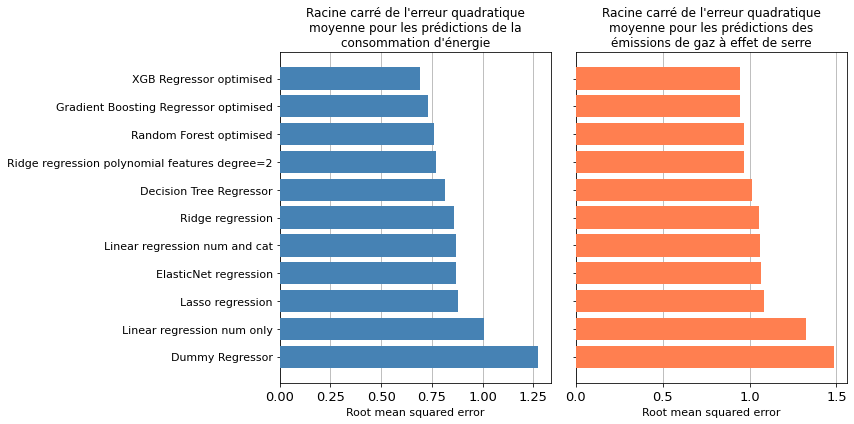

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax[0].barh(y=models_summary_SEU["model_name"], width=models_summary_SEU["test_root_mean_squared_error"], 
           color="steelblue", zorder=3)
ax[0].set_title("Racine carré de l'erreur quadratique\nmoyenne pour les prédictions de la\nconsommation d'énergie")
ax[0].set_xlabel("Root mean squared error")
ax[0].grid(axis="x")

ax[1].barh(y=models_summary_GHGE["model_name"], width=models_summary_GHGE["test_root_mean_squared_error"], 
           color="coral", zorder=3)
ax[1].set_title("Racine carré de l'erreur quadratique\nmoyenne pour les prédictions des\némissions de gaz à effet de serre")
ax[1].set_xlabel("Root mean squared error")
ax[1].set_yticklabels("")
ax[1].grid(axis="x")

#fig.savefig("classement_modeles.png", bbox_inches="tight", dpi=150);

## Conclusions

Pour notre problématique, les meilleurs modèles sont, de manière générale, les modèles ensemblistes de boosting. 

Le modèle *XGB Regressor* est au coude à coude avec le *gradient boosting* sur les performances pour la consommation d'énergie et très légèrement inférieur pour les émissions de gaz à effet de serre. Les temps de calcul sont très proches pour la consommation d'énergie (légèrement meilleurs pour le *XGB Regressor*) et meilleurs pour le *gradient boosting* dans le cas des émissions.

Au final, on préfèrera le modèle de **gradient boosting**. Il faudra toutefois veuiller à refaire de tests lorsque plus de données seront disponibles : les 2 modèles étant très proches, cela pourrait changer la donne.